### Forecast the Airlines Passengers data set. Prepare a document for model explaining.


### How many dummy variables you have created and RMSE value for model. Finally which model you will use for Forecasting.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from math import sqrt
import plotly.express as px
from scipy.stats import boxcox
import plotly.graph_objects as go
from pandas.plotting import lag_plot
import statsmodels.formula.api as smf 
from plotly.subplots import make_subplots
from statsmodels.tsa.holtwinters import Holt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_excel('Airlines+Data.xlsx')
df

,Month,Passengers
0,1995-01-01,112
1,1995-02-01,118
2,1995-03-01,132
3,1995-04-01,129
4,1995-05-01,121
...,...,...
91,2002-08-01,405
92,2002-09-01,355
93,2002-10-01,306
94,2002-11-01,271


#### Data Exploration

In [3]:
df.isnull().sum()

Month         0
Passengers    0
dtype: int64

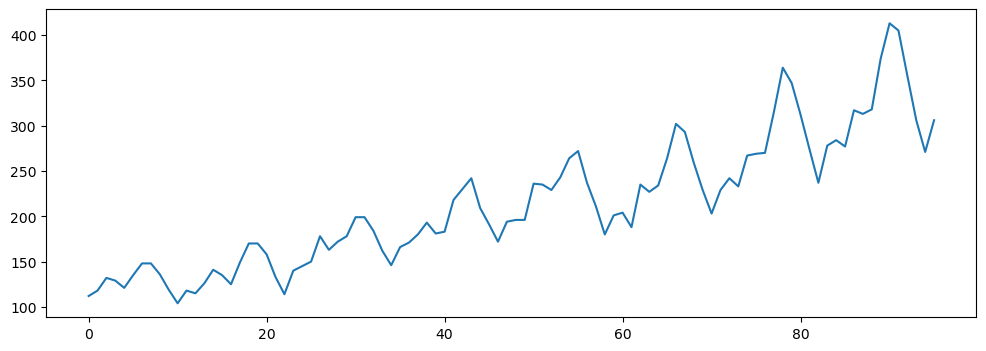

In [4]:
df.Passengers.plot(figsize=(12,4));

#### Descriptive Analysis

In [5]:
print('Shape of the data', df.shape)

Shape of the data (96, 2)


In [6]:
df.dtypes

Month         datetime64[ns]
Passengers             int64
dtype: object

In [7]:
df.nunique()

Month         96
Passengers    80
dtype: int64

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96 entries, 0 to 95
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Month       96 non-null     datetime64[ns]
 1   Passengers  96 non-null     int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 1.6 KB


In [9]:
df.describe()

,Month,Passengers
count,96,96.000000
mean,1998-12-16 05:00:00,213.708333
min,1995-01-01 00:00:00,104.000000
25%,1996-12-24 06:00:00,156.000000
50%,1998-12-16 12:00:00,200.000000
75%,2000-12-08 18:00:00,264.750000
max,2002-12-01 00:00:00,413.000000
std,NaN,71.918216


### Feature Engineering

#### Renaming the Month column into Date

In [10]:
df.rename({'Month':'Date'}, axis=1, inplace=True)

#### Making the Date as DateTime index for the Dataframe

In [11]:
airline = df.copy()
airline.set_index('Date', inplace=True)
airline.index.year

Index([1995, 1995, 1995, 1995, 1995, 1995, 1995, 1995, 1995, 1995, 1995, 1995,
       1996, 1996, 1996, 1996, 1996, 1996, 1996, 1996, 1996, 1996, 1996, 1996,
       1997, 1997, 1997, 1997, 1997, 1997, 1997, 1997, 1997, 1997, 1997, 1997,
       1998, 1998, 1998, 1998, 1998, 1998, 1998, 1998, 1998, 1998, 1998, 1998,
       1999, 1999, 1999, 1999, 1999, 1999, 1999, 1999, 1999, 1999, 1999, 1999,
       2000, 2000, 2000, 2000, 2000, 2000, 2000, 2000, 2000, 2000, 2000, 2000,
       2001, 2001, 2001, 2001, 2001, 2001, 2001, 2001, 2001, 2001, 2001, 2001,
       2002, 2002, 2002, 2002, 2002, 2002, 2002, 2002, 2002, 2002, 2002, 2002],
      dtype='int32', name='Date')

In [12]:
airline.head()

,Passengers
Date,
1995-01-01,112
1995-02-01,118
1995-03-01,132
1995-04-01,129
1995-05-01,121


#### Separating Month and Year into Separate Column for Visualization and removing meaningful insight of the data

In [13]:
df["Date"]  = pd.to_datetime(df.Date, format="%b-%y")
df["month"] = df.Date.dt.strftime("%b") # month extraction
df["year"]  = df.Date.dt.strftime("%Y") # year extraction
df.head(10)

,Date,Passengers,month,year
0,1995-01-01,112,Jan,1995
1,1995-02-01,118,Feb,1995
2,1995-03-01,132,Mar,1995
3,1995-04-01,129,Apr,1995
4,1995-05-01,121,May,1995
5,1995-06-01,135,Jun,1995
6,1995-07-01,148,Jul,1995
7,1995-08-01,148,Aug,1995
8,1995-09-01,136,Sep,1995
9,1995-10-01,119,Oct,1995


### Data Visualization

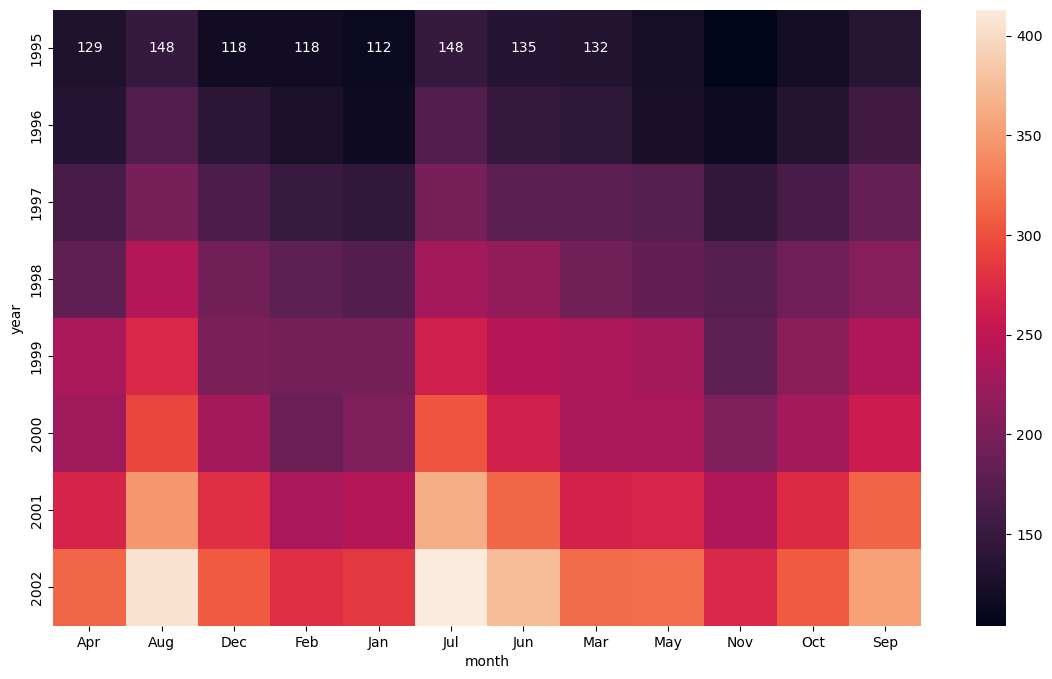

In [14]:
plt.figure(figsize=(14,8))
heatmap_y_month = pd.pivot_table(data=df,values="Passengers",index="year",columns="month",aggfunc="mean",fill_value=0)
sns.heatmap(heatmap_y_month,annot=True,fmt="g") #fmt is format of the grid values
plt.show()

### Line plot

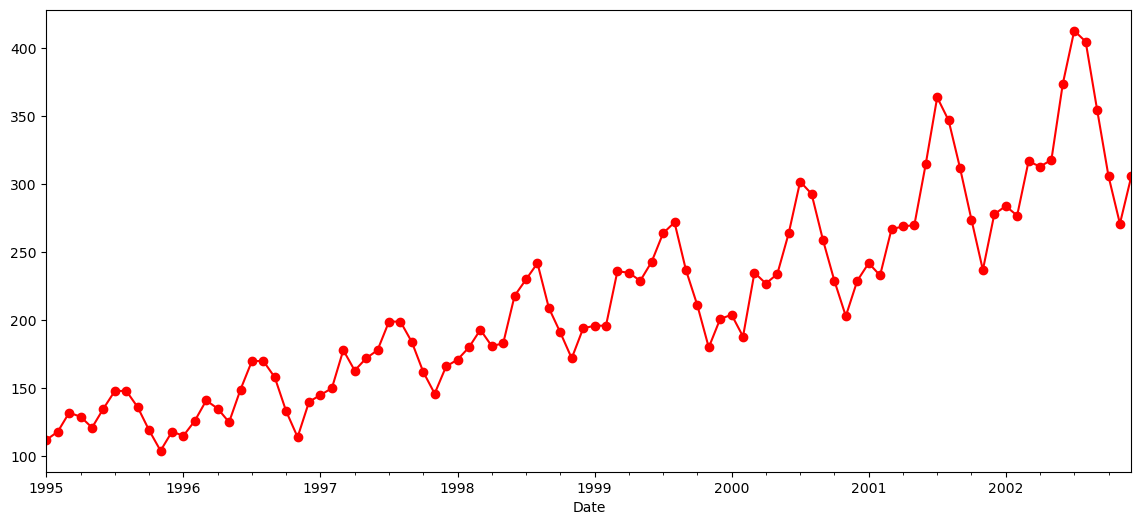

In [15]:
airline['Passengers'].plot(figsize=(14,6),color='red',marker='o')
plt.show()

We can see that there is an increasing Trend. So, Trend is not constant.
Variance is also not constant.
Hence the time serise is not stationary.

### Yearly Passenger Analysis

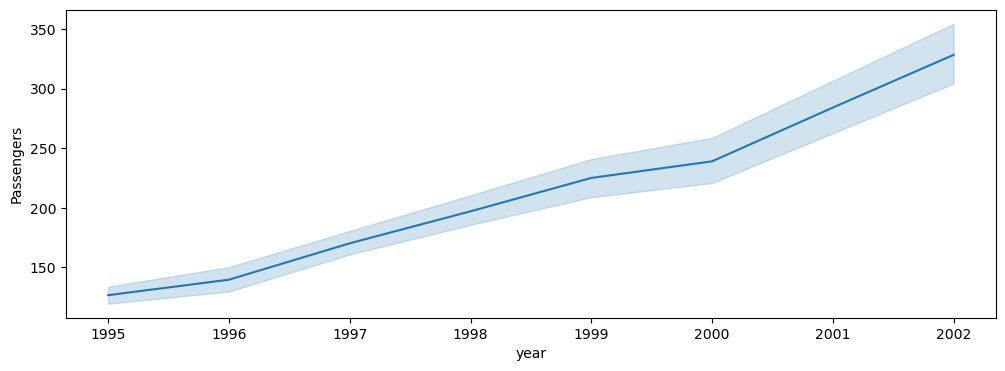

In [16]:
plt.figure(figsize=(12,4))
sns.lineplot(x="year", y="Passengers", data=df)
import warnings

def fxn():
    warnings.warn("deprecated", DeprecationWarning)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fxn()

#### Box Plot of Each Year by Monthly Intervals

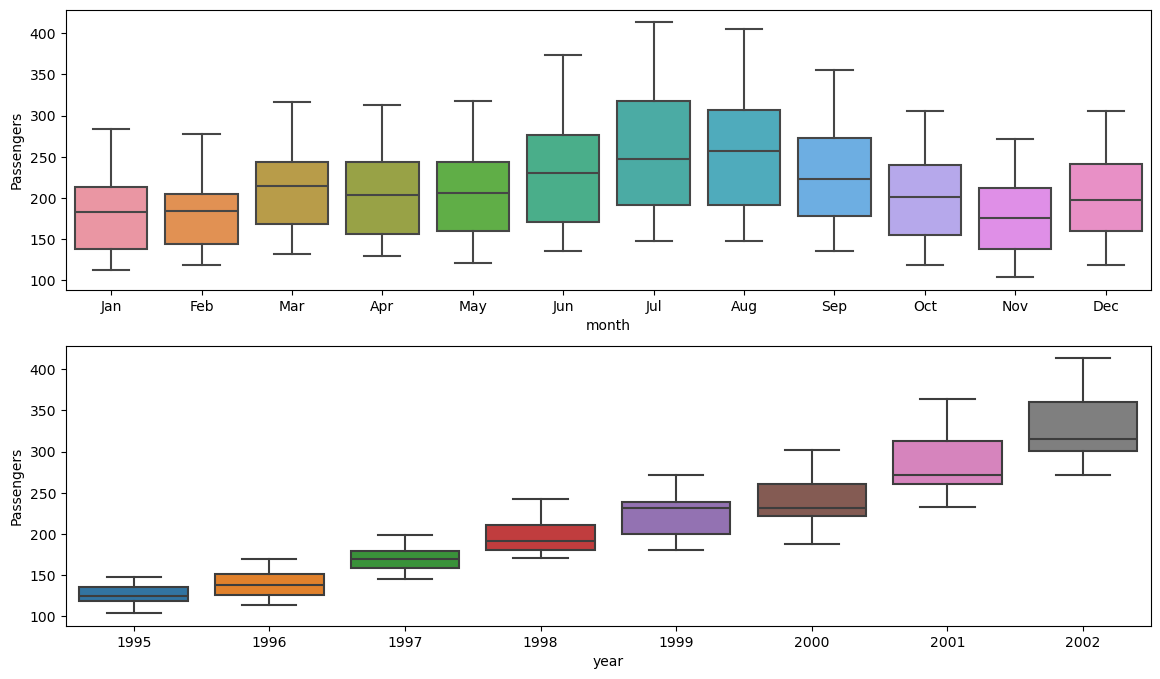

In [17]:
plt.figure(figsize=(14,8))
plt.subplot(211)
sns.boxplot(x="month", y="Passengers", data=df)
plt.subplot(212)
sns.boxplot(x="year", y="Passengers", data=df)
plt.show()

#### Histogram and Density Plots

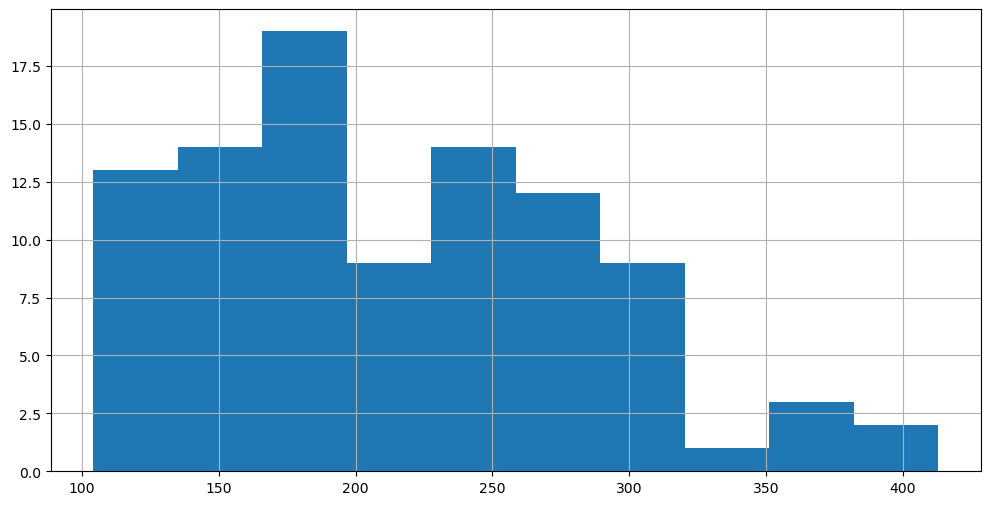

In [18]:
df.Passengers.hist(figsize=(12,6))
plt.show()


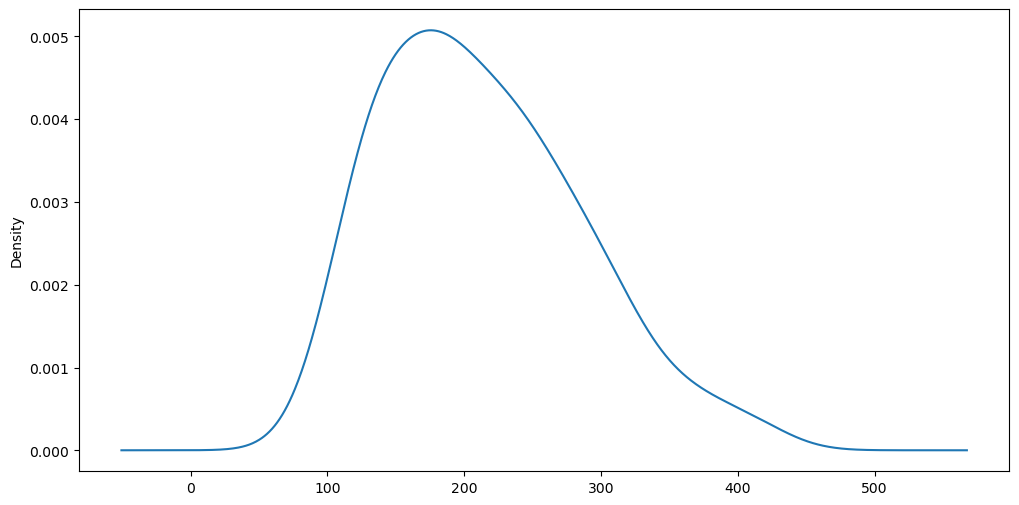

In [19]:
df.Passengers.plot(kind='kde', figsize=(12,6))
plt.show()

#### Lag plot

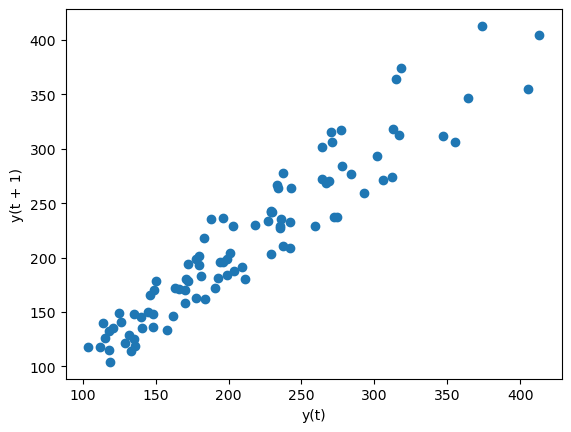

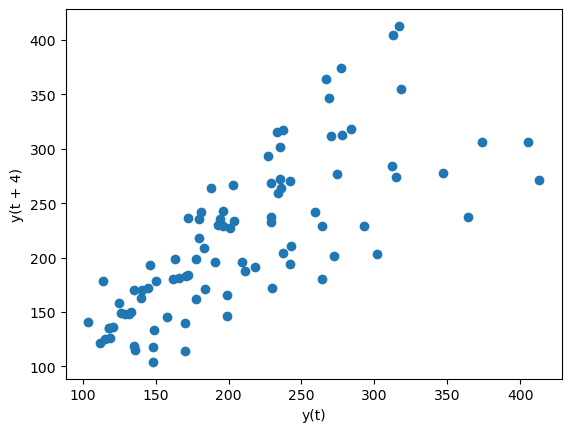

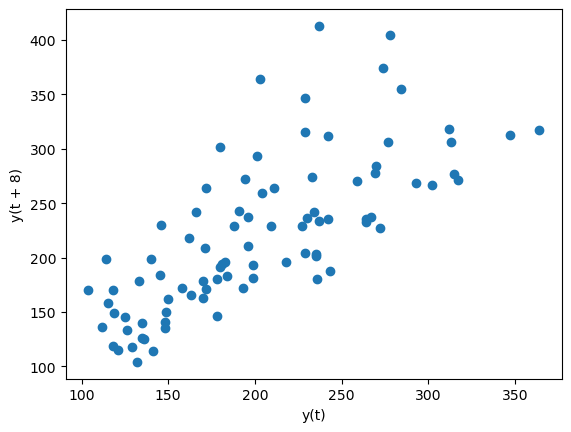

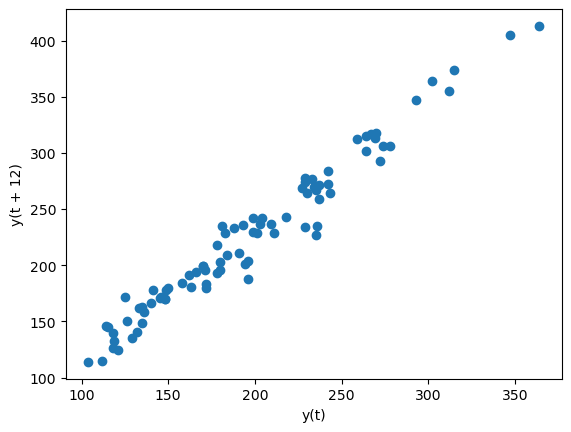

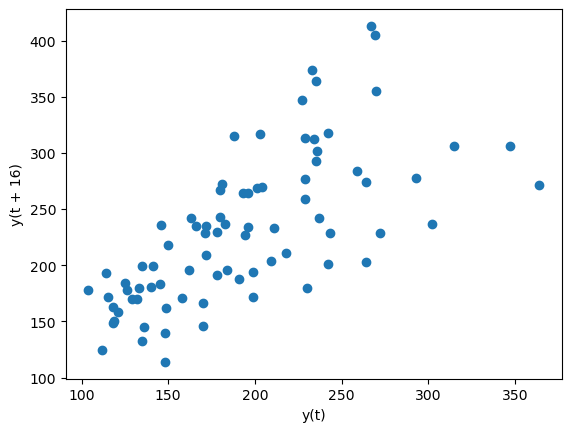

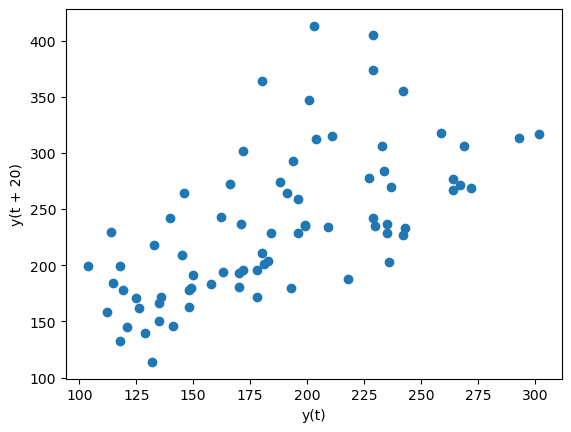

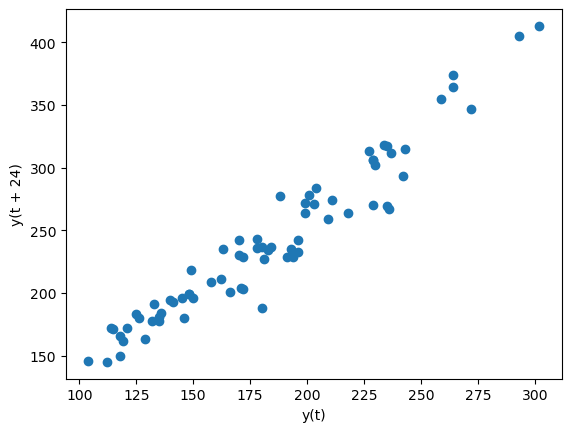

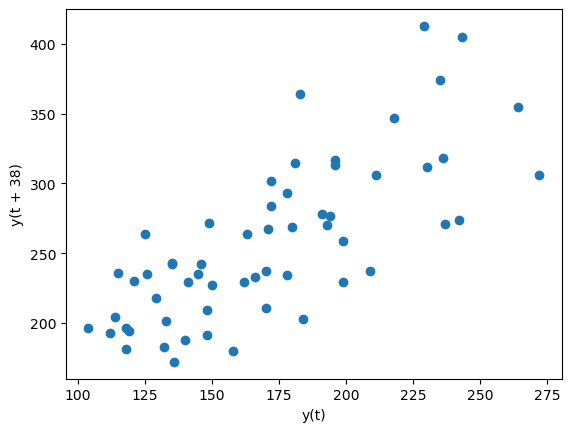

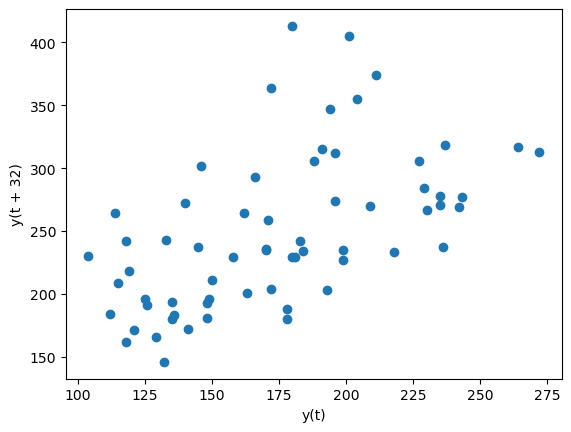

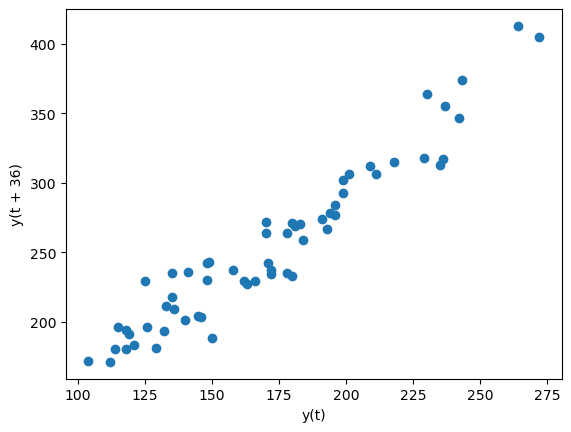

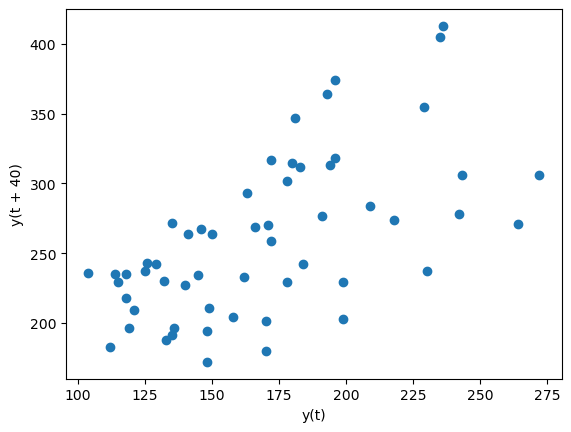

In [20]:
# create a scatter plot
for i in [1, 4, 8, 12, 16, 20, 24, 38, 32, 36, 40]:
    #plt.figure(figsize=(12,8))
    lag_plot(df.Passengers, lag=i)
    plt.show()

#### Moving Average

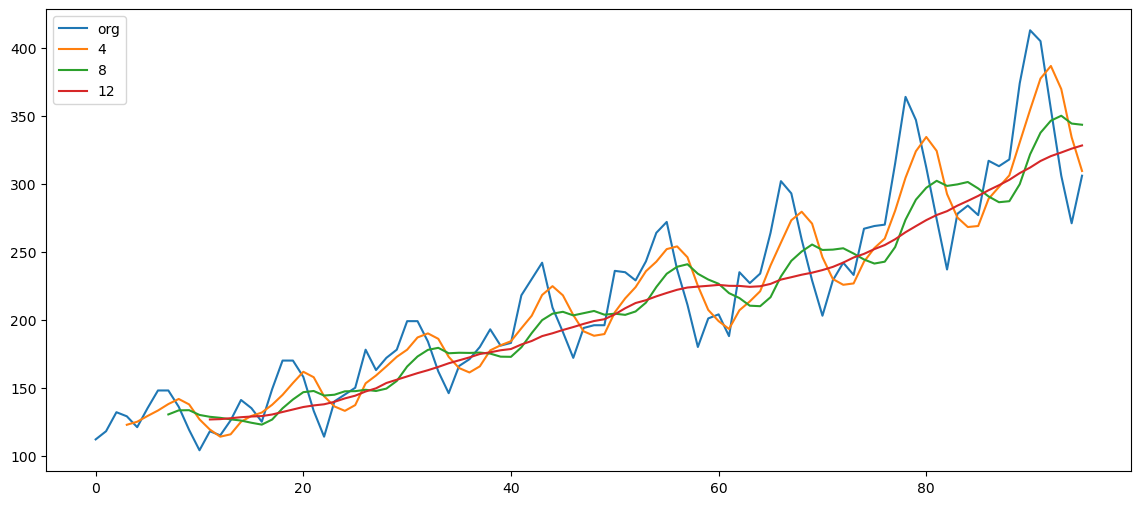

In [21]:
plt.figure(figsize=(14,6))
df.Passengers.plot(label="org")
for i in range(4,13,4):
    df["Passengers"].rolling(i).mean().plot(label=str(i))
plt.legend(loc='best')
plt.show()

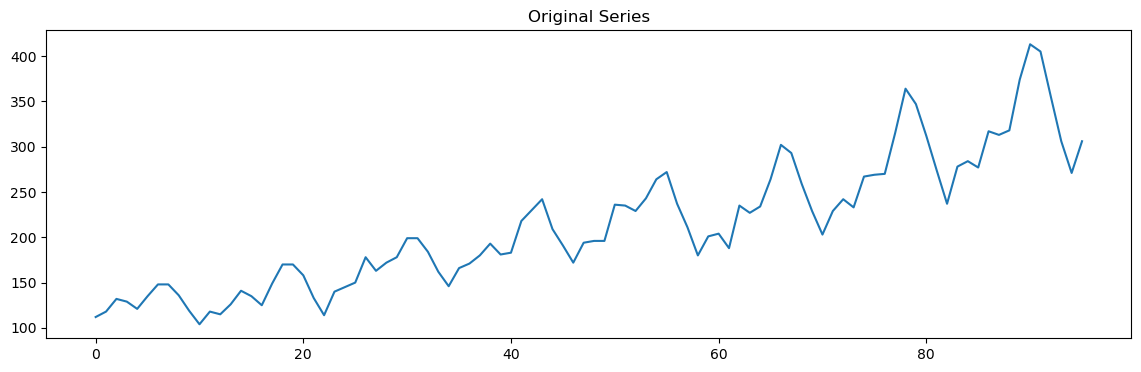

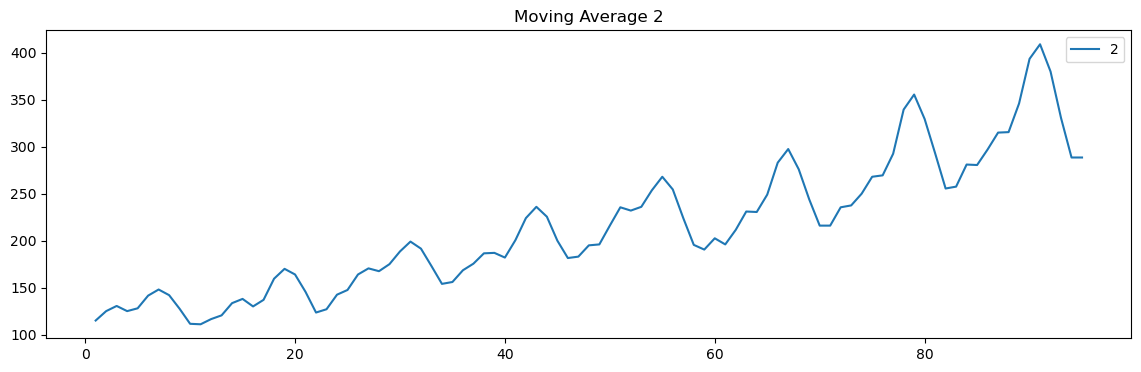

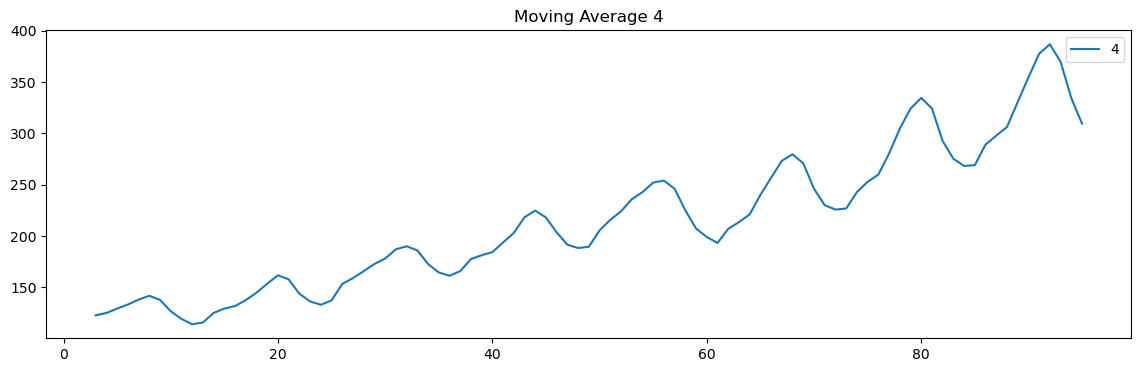

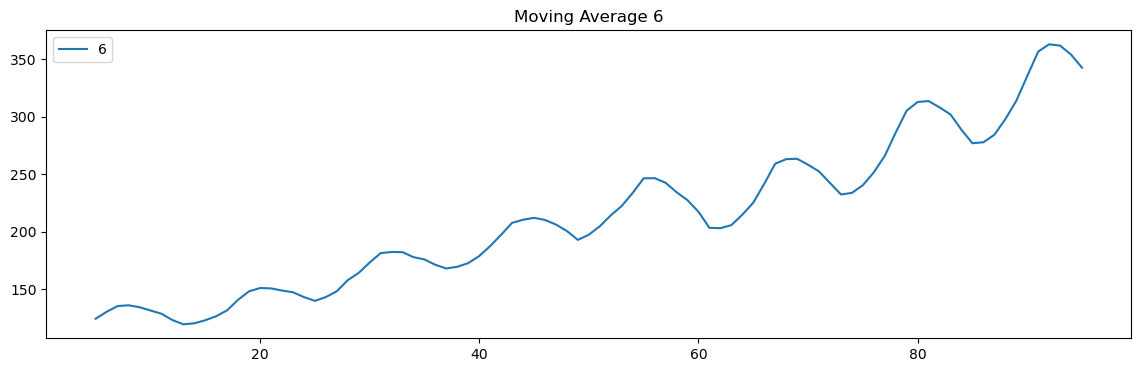

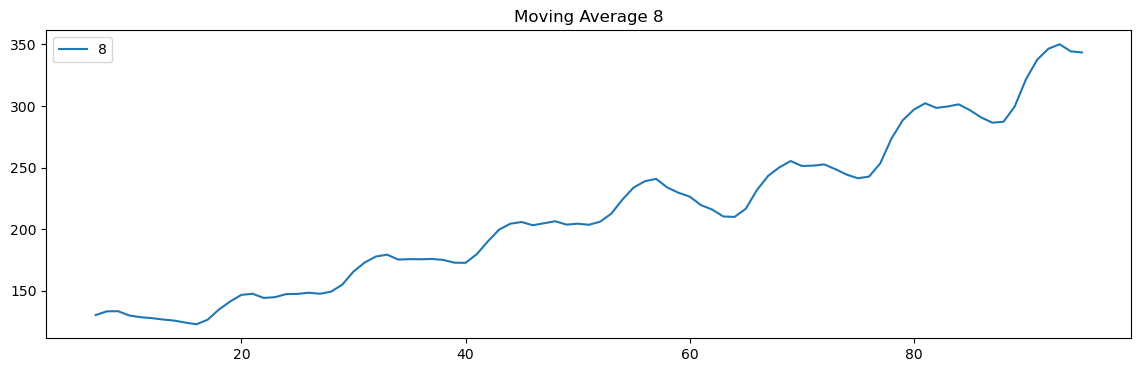

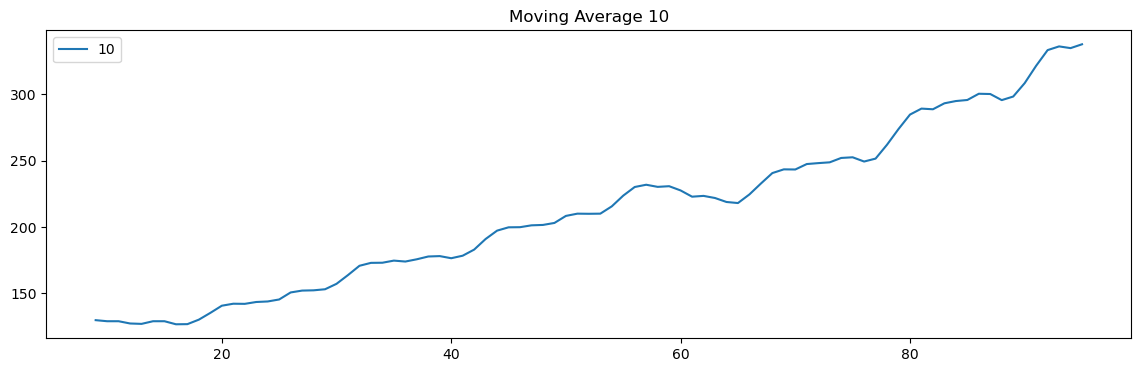

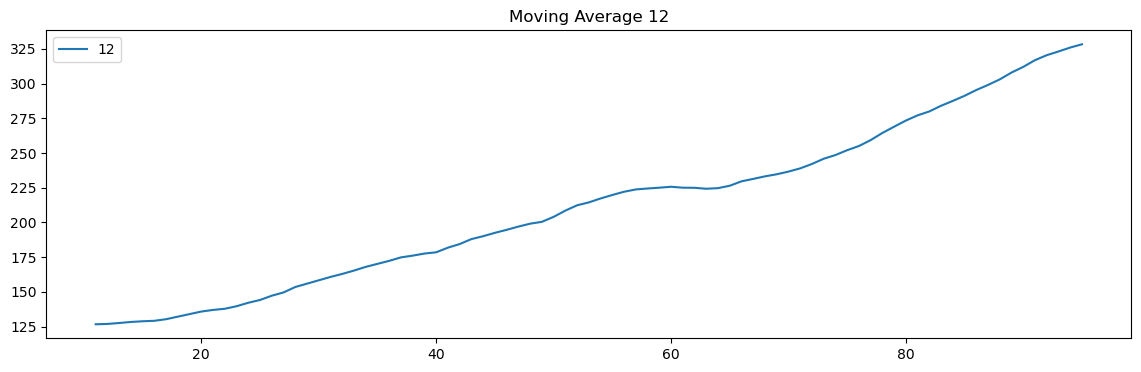

In [22]:
plt.figure(figsize=(14,4))
df.Passengers.plot(label="org")
plt.title("Original Series")
for i in range(2,13,2):
    plt.figure(figsize=(14,4))
    df["Passengers"].rolling(i).mean().plot(label=str(i))
    plt.title("Moving Average "+str(i))
    plt.legend(loc='best')
    plt.show()

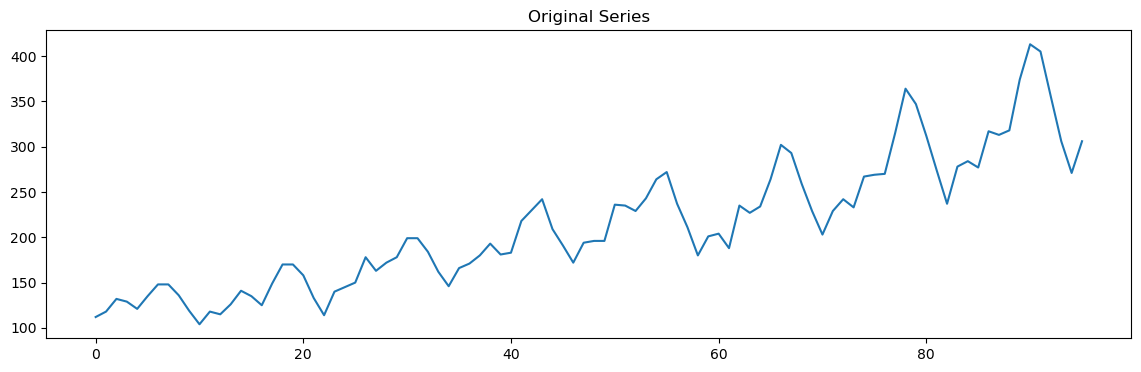

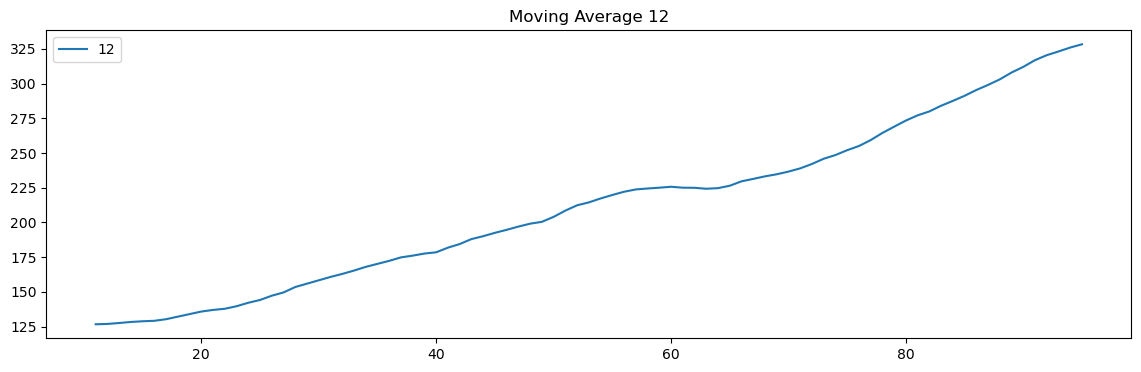

In [23]:
plt.figure(figsize=(14,4))
df.Passengers.plot(label="org")
plt.title("Original Series")
plt.figure(figsize=(14,4))
df["Passengers"].rolling(12).mean().plot(label=str(12))
plt.title("Moving Average "+str(12))
plt.legend(loc='best')
plt.show()

### Time series decomposition plot

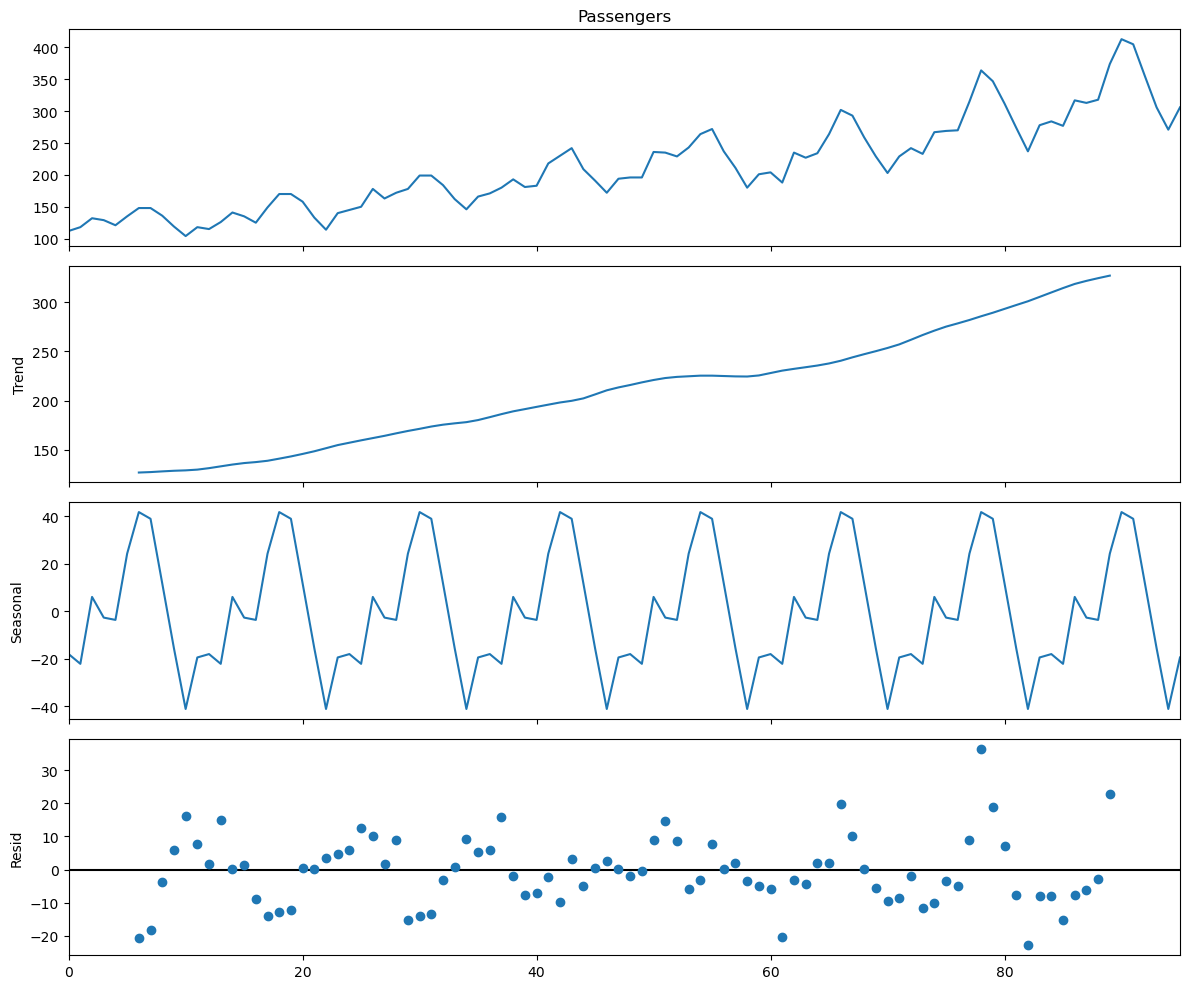

In [24]:
decompose_ts_add = seasonal_decompose(df.Passengers, period=12)
with plt.rc_context():
    plt.rc("figure", figsize=(12,10))
    decompose_ts_add.plot()
    plt.show()

### ACF plots and PACF plots

#### Autocorrelation Function (ACF)

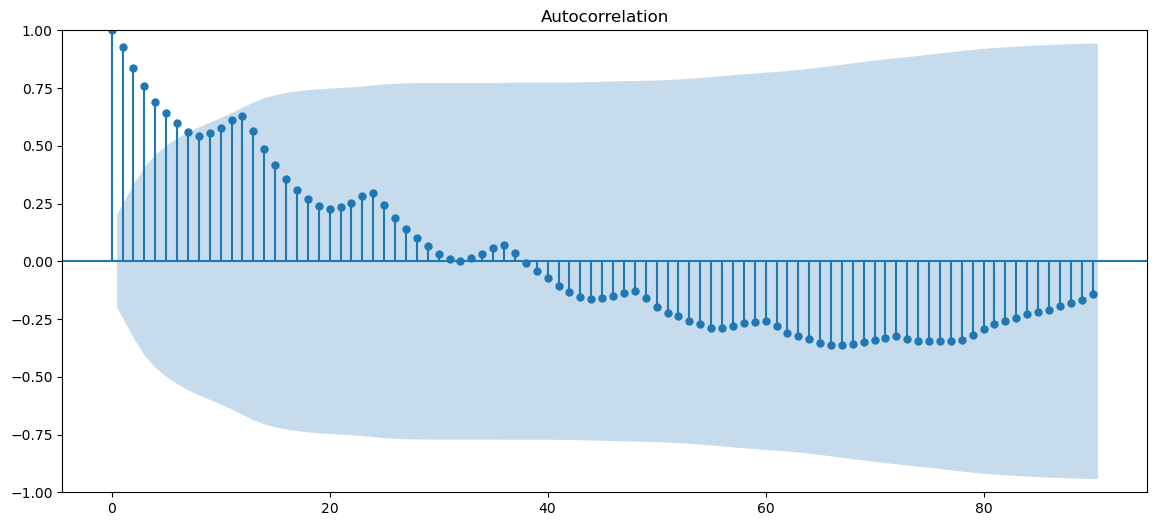

In [25]:
import statsmodels.graphics.tsaplots as tsa_plots
with plt.rc_context():
    plt.rc("figure", figsize=(14,6))
    tsa_plots.plot_acf(df.Passengers, lags=90)
    plt.show()

Autocorrelation is the correlation between a time series (signal) and a delayed version of itself, while the ACF plots the correlation coefficient against the lag, and it’s a visual representation of autocorrelation

### Partial Autocorrelation Function (PACF)

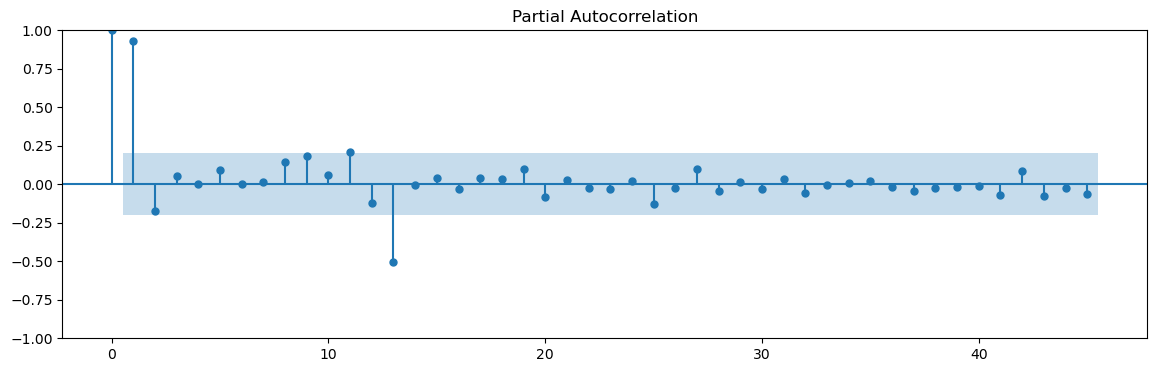

In [26]:
import statsmodels.graphics.tsaplots as tsa_plots
with plt.rc_context():
    plt.rc("figure", figsize=(14,4))
    tsa_plots.plot_pacf(df.Passengers,lags=45)
    plt.show()

A partial autocorrelation function captures a “direct” correlation between time series and a lagged version of itself.

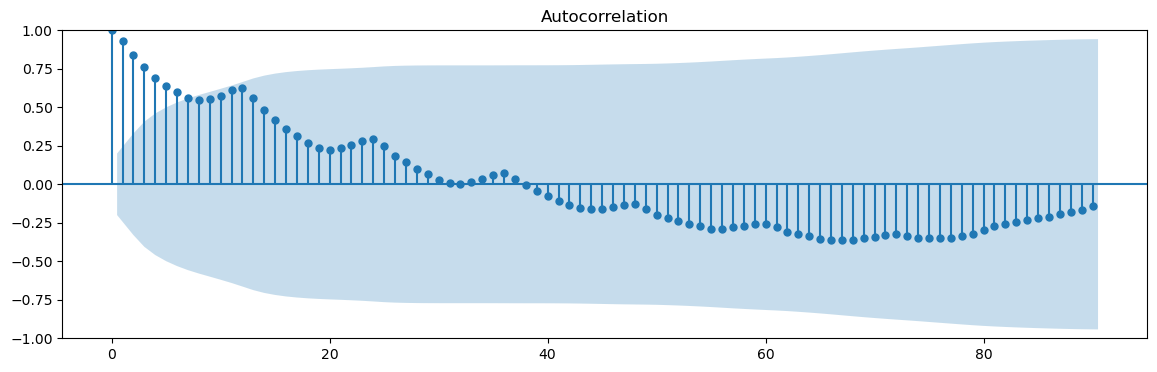

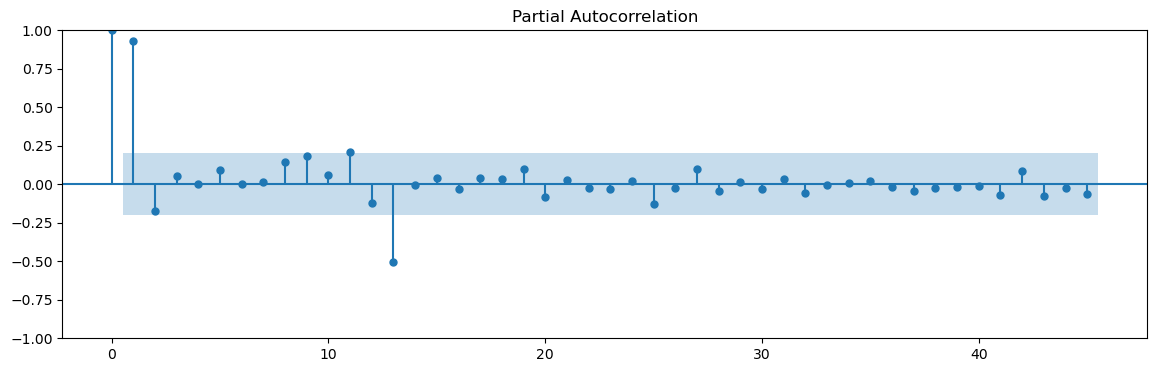

In [27]:
import statsmodels.graphics.tsaplots as tsa_plots
with plt.rc_context():
    plt.rc("figure", figsize=(14,4))
    tsa_plots.plot_acf(df.Passengers,lags=90)
    tsa_plots.plot_pacf(df.Passengers,lags=45)
    plt.show()

In [28]:
visual = airline.copy()
visual.reset_index(inplace=True)
visual['date'] = pd.to_datetime(visual['Date'])
visual['year'] = visual['Date'].dt.year
visual['month'] = visual['Date'].dt.month
visual['week'] = visual['Date'].dt.isocalendar().week
visual['quarter'] = visual['Date'].dt.quarter
visual['day_of_week'] = visual['Date'].dt.day_name()
visual.drop('Date', axis =1 , inplace= True)
visual.head(10)

,Passengers,date,year,month,week,quarter,day_of_week
0,112,1995-01-01,1995,1,52,1,Sunday
1,118,1995-02-01,1995,2,5,1,Wednesday
2,132,1995-03-01,1995,3,9,1,Wednesday
3,129,1995-04-01,1995,4,13,2,Saturday
4,121,1995-05-01,1995,5,18,2,Monday
5,135,1995-06-01,1995,6,22,2,Thursday
6,148,1995-07-01,1995,7,26,3,Saturday
7,148,1995-08-01,1995,8,31,3,Tuesday
8,136,1995-09-01,1995,9,35,3,Friday
9,119,1995-10-01,1995,10,39,4,Sunday


In [29]:
visual.year.unique()

array([1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002])

### Time Series Decomposition

1. Seasonality
2. Trend

#### Additive Seasonal Decomposition

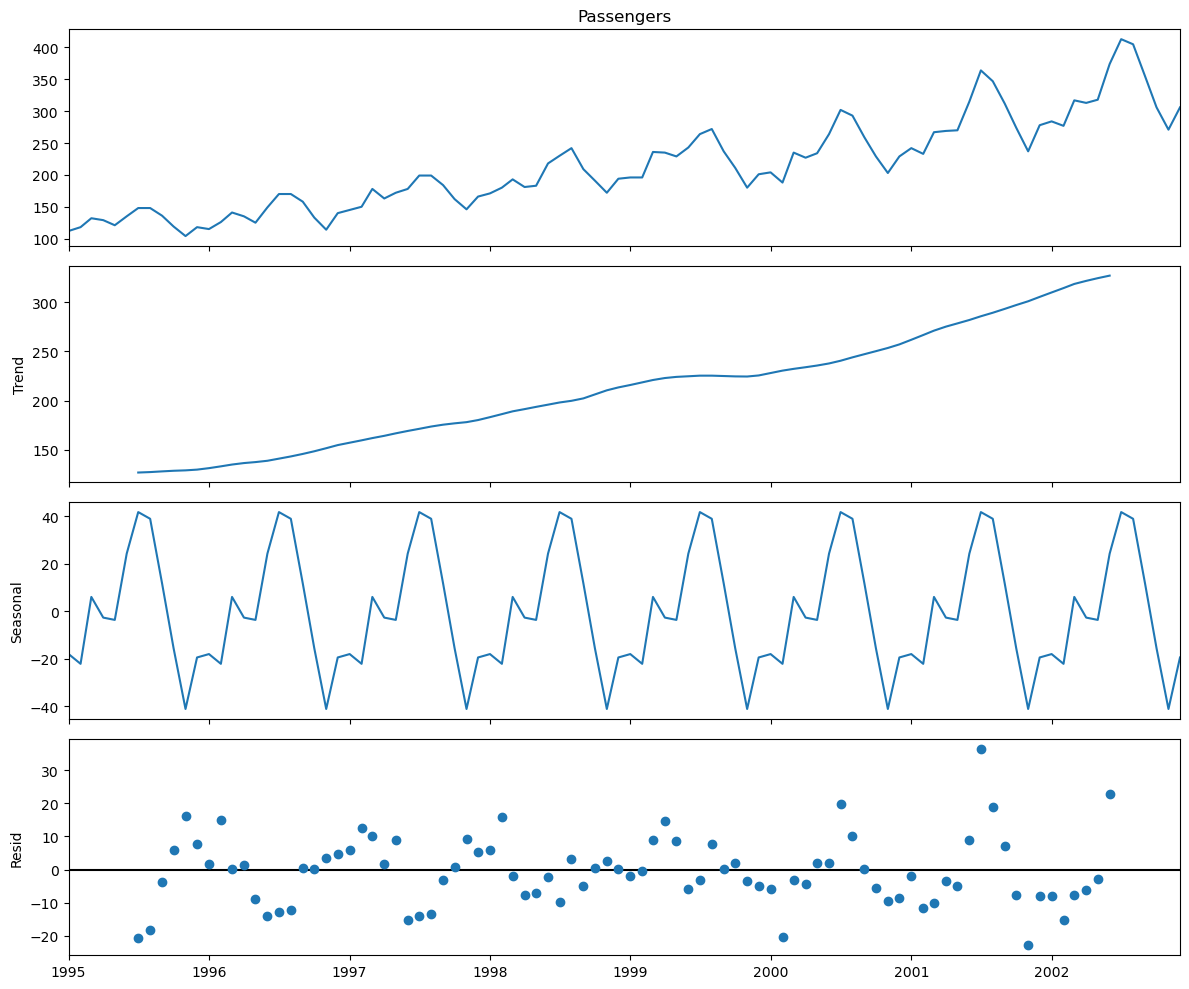

In [30]:
decompose_ts_add = seasonal_decompose(airline.Passengers, period=12, model='additive')
with plt.rc_context():
    plt.rc("figure", figsize=(12,10))
    decompose_ts_add.plot()
    plt.show()

Observed - Actual data
Trend - Increasing or decreasing trend.
Seasonal -
Varies from +50 to -50 with the mean 0.
Each cycle represents each year trend.
The value in the Y-axis has to be added to the Trend plot value to get the actual value of that year. E.g.:- For the year 1950 Nov, the seasonal value is +50 and the trend value is 100. Hence, teh actual value(passengers number) will (seasonal+Trend) value = 50+100 = 150.
Residual - It is the noise pattern of the time series data for each year, which was not captured by the two components - Trend and Seasonality. Residual is the left over after decomposition of the two major components (Trend and Seasonality)

#### Multiplicative Seasonal Decomposition

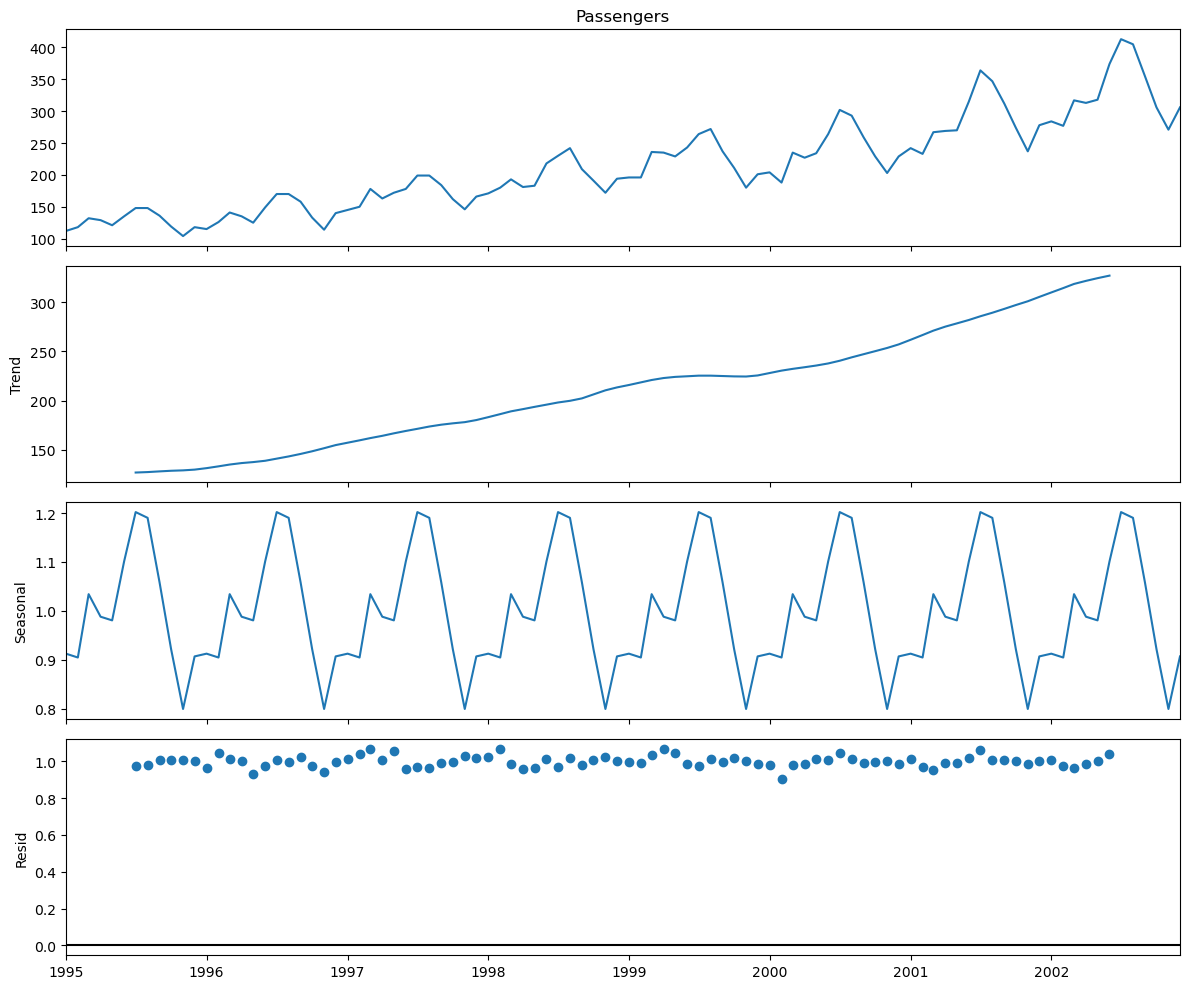

In [31]:
decompose_ts_add = seasonal_decompose(airline.Passengers,period=12, model='multiplicative')
with plt.rc_context():
    plt.rc("figure", figsize=(12,10))
    decompose_ts_add.plot()
    plt.show()

Varies from 0.8 to 1.2
The value in the Y-axis has to be multiplied to the Trend plot value to get the actual value of that year. E.g.:- For the year 1950 Nov, the seasonal value is 1.2 and the trend value is 100. Hence, the actual value(passengers number) will (seasonal X Trend) value = 1.2 X 100 = 120.

#### Splitting Train and Test Data

##### Leaving Test Data with 2 Years of Time Series

In [32]:
size = 72
train_data = airline[:size]
test_data = airline[size:]

In [33]:
print('Train:',train_data.index.min(),train_data.index.max(),'\n',
'Test:',test_data.index.min(),test_data.index.max())

Train: 1995-01-01 00:00:00 2000-12-01 00:00:00 
 Test: 2001-01-01 00:00:00 2002-12-01 00:00:00


##### forecat for the last two years. 2001 and 2002. Last 24 records contain From 2001 to 2002 data.

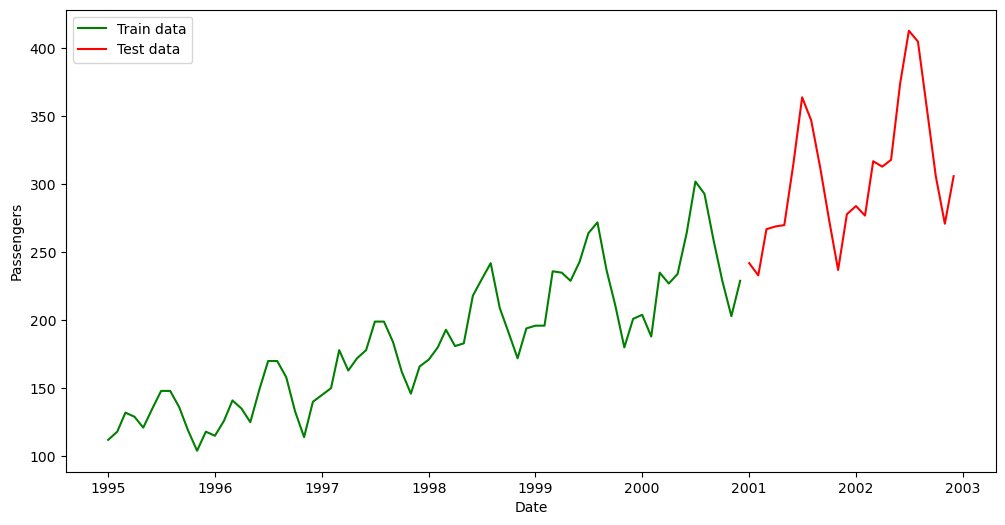

In [34]:
plt.figure(figsize=(12,6))
plt.xlabel('Date')
plt.ylabel('Passengers')
plt.plot(train_data, 'green', label='Train data')
plt.plot(test_data, 'red', label='Test data')
plt.legend()
plt.show()


### Evaluation Metric MAPE

In [35]:
def MAPE(pred,org):
    temp = np.abs((pred-org)/org)*100
    return np.mean(temp)

#### Exponential Methods

##### Simple Exponential Method

##### Using Forecast Attribute

In [36]:
ses_model = SimpleExpSmoothing(train_data['Passengers']).fit(optimized=True)
test_pred_ses = ses_model.forecast(24)
train_pred_ses = ses_model.fittedvalues
test_rmse_ses = sqrt(mean_squared_error(test_pred_ses,test_data.Passengers))
train_rmse_ses = sqrt(mean_squared_error(train_pred_ses,train_data))
mape_ses = MAPE(test_pred_ses,test_data.Passengers)
print('Simple Exponential Method Evaluation',"\n",\
'Mean Absolute Percent Error   = {}'.format(mape_ses),"\n",\
'Train Root Mean Squared Error = {}'.format(train_rmse_ses),"\n",
'Test Root Mean Squared Error  = {}'.format(test_rmse_ses))

Simple Exponential Method Evaluation 
 Mean Absolute Percent Error   = 23.38228335004472 
 Train Root Mean Squared Error = 19.031771730910982 
 Test Root Mean Squared Error  = 91.11325402904403


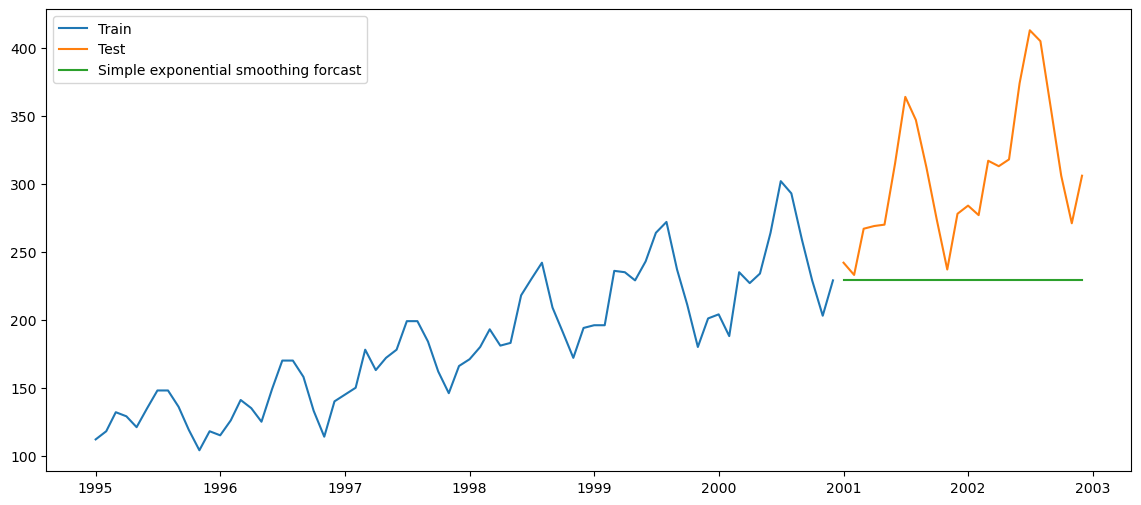

In [37]:
plt.figure(figsize=(14,6))
plt.plot(train_data, label='Train')
plt.plot(test_data, label='Test')
plt.plot(test_pred_ses, label='Simple exponential smoothing forcast')
plt.legend(loc='best')
plt.show()

### Holt method (Double Exponential)

##### Captures both Level and Trend .

In [38]:
dexp_model  = Holt(train_data).fit(optimized=True)
test_pred_dexp = dexp_model.forecast(24)
train_pred_dexp = dexp_model.fittedvalues
test_rmse_dexp = sqrt(mean_squared_error(test_pred_dexp,test_data.Passengers))
train_rmse_dexp = sqrt(mean_squared_error(train_pred_dexp,train_data))
mape_dexp = MAPE(test_pred_dexp,test_data.Passengers)
print('Simple Exponential Method Evaluation',"\n",\
'Mean Absolute Percent Error   = {}'.format(mape_dexp),"\n",\
'Train Root Mean Squared Error = {}'.format(train_rmse_dexp),"\n",
'Test Root Mean Squared Error  = {}'.format(test_rmse_dexp))

Simple Exponential Method Evaluation 
 Mean Absolute Percent Error   = 13.7905908588713 
 Train Root Mean Squared Error = 19.3022744805411 
 Test Root Mean Squared Error  = 59.96915188985025


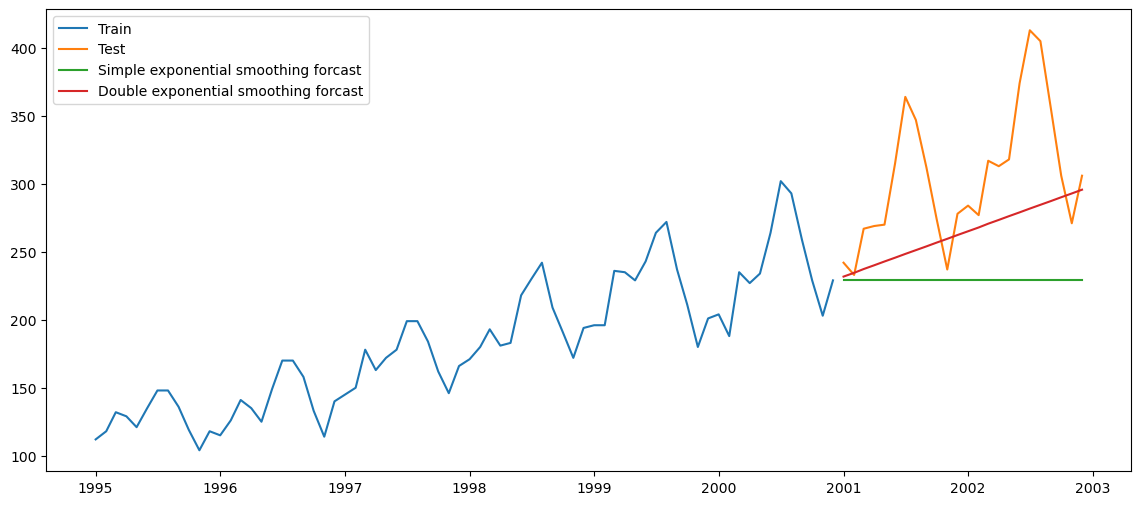

In [39]:
plt.figure(figsize=(14,6))
plt.plot(train_data, label='Train')
plt.plot(test_data, label='Test')
plt.plot(test_pred_ses, label='Simple exponential smoothing forcast')
plt.plot(test_pred_dexp, label='Double exponential smoothing forcast')
plt.legend(loc='best')
plt.show()

### Holts winter exponential smoothing with additive seasonality and trend (Triple Exponential)

##### Captures Level, Trend and Seasonality.

In [40]:
texp_add_model  = ExponentialSmoothing(train_data,seasonal="add",trend="add",seasonal_periods=12).fit(optimized=True)
test_pred_ad_texp = texp_add_model.forecast(24)
train_pred_ad_texp = texp_add_model.fittedvalues
test_rmse_ad_texp = sqrt(mean_squared_error(test_pred_ad_texp,test_data.Passengers))
train_rmse_ad_texp = sqrt(mean_squared_error(train_pred_ad_texp,train_data))
mape_ad_texp = MAPE(test_pred_ad_texp,test_data.Passengers)
print('Triple Exponential with Additive Trend and Seosonality Method Evaluation',"\n",\
'Mean Absolute Percent Error   = {}'.format(mape_ad_texp),"\n",\
'Train Root Mean Squared Error = {}'.format(train_rmse_ad_texp),"\n",
'Test Root Mean Squared Error  = {}'.format(test_rmse_ad_texp))

Triple Exponential with Additive Trend and Seosonality Method Evaluation 
 Mean Absolute Percent Error   = 12.084270987248692 
 Train Root Mean Squared Error = 7.751303510644329 
 Test Root Mean Squared Error  = 47.56853148096913


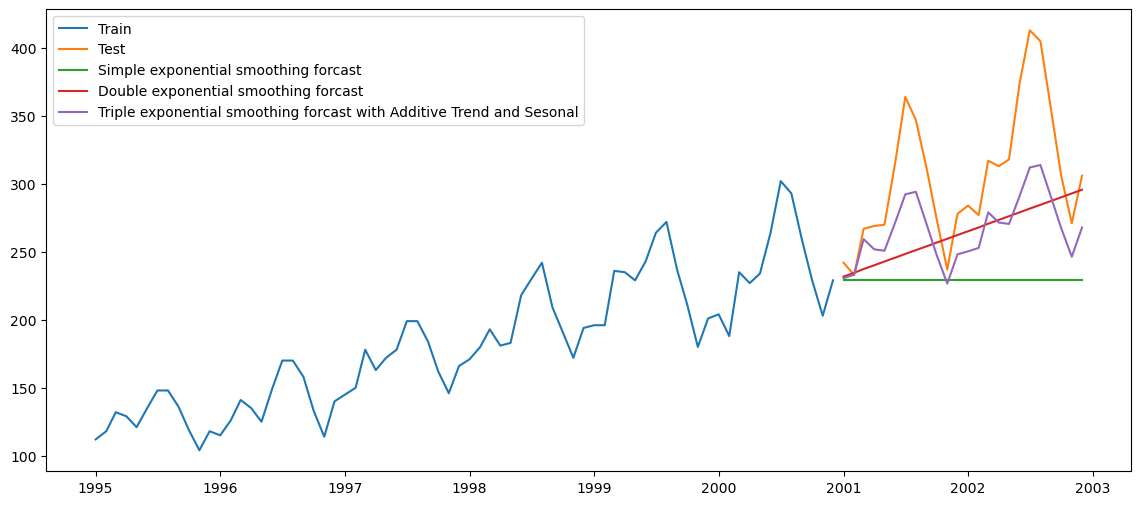

In [41]:
plt.figure(figsize=(14,6))
plt.plot(train_data, label='Train')
plt.plot(test_data, label='Test')
plt.plot(test_pred_ses, label='Simple exponential smoothing forcast')
plt.plot(test_pred_dexp, label='Double exponential smoothing forcast')
plt.plot(test_pred_ad_texp, label='Triple exponential smoothing forcast with Additive Trend and Sesonal')
plt.legend(loc='best')
plt.show()

#### Holts winter exponential smoothing with multiplicative seasonality and additive trend (Triple Exponential)

In [42]:
texp_mul_ad_model  = ExponentialSmoothing(train_data,seasonal="mul",trend="add",seasonal_periods=12).fit(optimized=True)
test_pred_mul_ad_texp = texp_mul_ad_model.forecast(24)
train_pred_mul_ad_texp = texp_mul_ad_model.fittedvalues
test_rmse_mul_ad_texp = sqrt(mean_squared_error(test_pred_mul_ad_texp,test_data.Passengers))
train_rmse_mul_ad_texp = sqrt(mean_squared_error(train_pred_mul_ad_texp,train_data))
mape_mul_ad_texp = MAPE(test_pred_mul_ad_texp,test_data.Passengers)
print('Triple Exponential Method with Multiplicative Seasonality and Additive Trend',"\n",\
'Mean Absolute Percent Error   = {}'.format(mape_mul_ad_texp),"\n",\
'Train Root Mean Squared Error = {}'.format(train_rmse_mul_ad_texp),"\n",
'Test Root Mean Squared Error  = {}'.format(test_rmse_mul_ad_texp))

Triple Exponential Method with Multiplicative Seasonality and Additive Trend 
 Mean Absolute Percent Error   = 9.368507048672802 
 Train Root Mean Squared Error = 6.386634437545614 
 Test Root Mean Squared Error  = 34.989900508860515


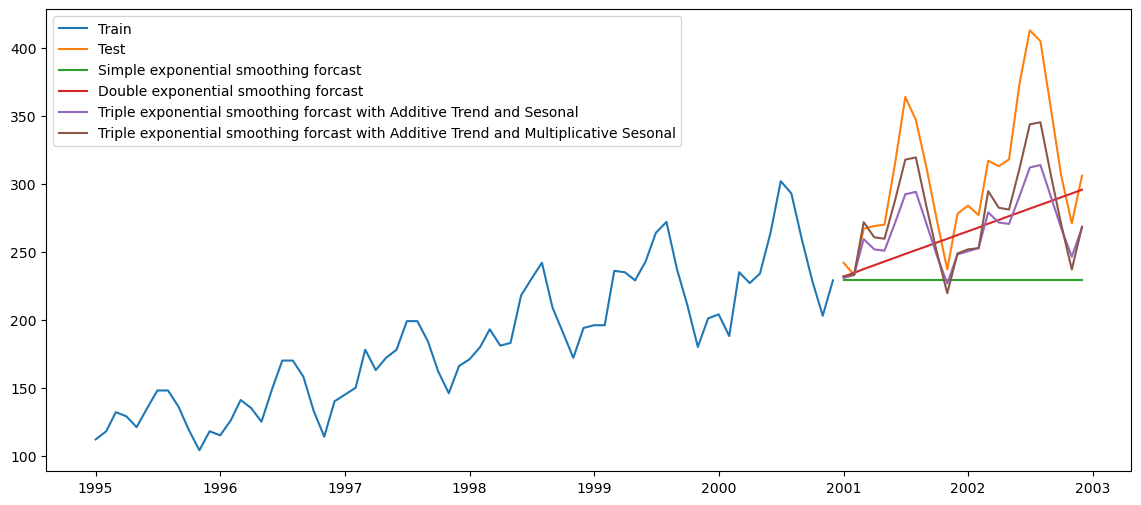

In [43]:
plt.figure(figsize=(14,6))
plt.plot(train_data, label='Train')
plt.plot(test_data, label='Test')
plt.plot(test_pred_ses, label='Simple exponential smoothing forcast')
plt.plot(test_pred_dexp, label='Double exponential smoothing forcast')
plt.plot(test_pred_ad_texp, label='Triple exponential smoothing forcast with Additive Trend and Sesonal')
plt.plot(test_pred_mul_ad_texp, label='Triple exponential smoothing forcast with Additive Trend and Multiplicative Sesonal')
plt.legend(loc='best')
plt.show()

### Holts winter exponential smoothing with Additive seasonality and multiplicative trend (Triple Exponential)

In [44]:
texp_ad_mul_model = ExponentialSmoothing(train_data,seasonal="add",trend="mul",
                    seasonal_periods=12).fit(smoothing_level=0.1, smoothing_slope=0.5)
test_pred_ad_mul_texp  = texp_ad_mul_model.forecast(24)
train_pred_ad_mul_texp  = texp_ad_mul_model.fittedvalues
test_rmse_ad_mul_texp  = sqrt(mean_squared_error(test_pred_ad_mul_texp ,test_data.Passengers))
train_rmse_ad_mul_texp  = sqrt(mean_squared_error(train_pred_ad_mul_texp ,train_data))
mape_ad_mul_texp  = MAPE(test_pred_ad_mul_texp,test_data.Passengers)
print('Triple Exponential Method with Additive Seasonality and Multiplicative Trend',"\n",\
'Mean Absolute Percent Error   = {}'.format(mape_ad_mul_texp ),"\n",\
'Train Root Mean Squared Error = {}'.format(train_rmse_ad_mul_texp ),"\n",
'Test Root Mean Squared Error  = {}'.format(test_rmse_ad_mul_texp ))

Triple Exponential Method with Additive Seasonality and Multiplicative Trend 
 Mean Absolute Percent Error   = 12.720038697644116 
 Train Root Mean Squared Error = 12.745961849041036 
 Test Root Mean Squared Error  = 45.89160554538598


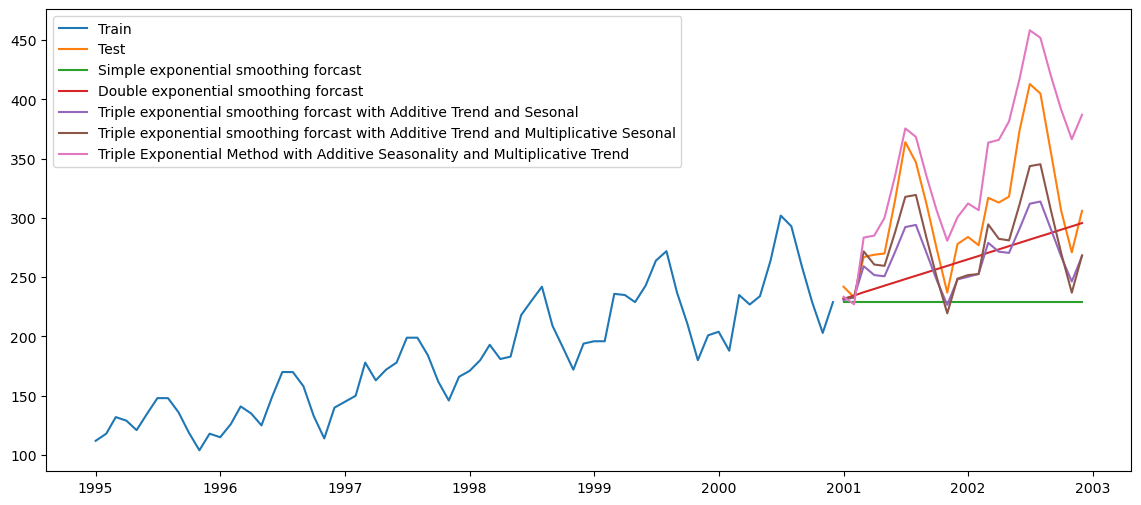

In [45]:
plt.figure(figsize=(14,6))
plt.plot(train_data, label='Train')
plt.plot(test_data, label='Test')
plt.plot(test_pred_ses, label='Simple exponential smoothing forcast')
plt.plot(test_pred_dexp, label='Double exponential smoothing forcast')
plt.plot(test_pred_ad_texp, label='Triple exponential smoothing forcast with Additive Trend and Sesonal')
plt.plot(test_pred_mul_ad_texp, label='Triple exponential smoothing forcast with Additive Trend and Multiplicative Sesonal')
plt.plot(test_pred_ad_mul_texp, label='Triple Exponential Method with Additive Seasonality and Multiplicative Trend')
plt.legend(loc='best')
plt.show()

### Holts winter exponential smoothing with multiplicative seasonality and multiplicative trend (Triple Exponential)

In [46]:
texp_mul_model  = ExponentialSmoothing(train_data,seasonal="mul",trend="mul",seasonal_periods=12).fit(optimized=True)
test_pred_mul_texp  = texp_mul_model.forecast(24)
train_pred_mul_texp  = texp_mul_model.fittedvalues
test_rmse_mul_texp  = sqrt(mean_squared_error(test_pred_mul_texp ,test_data.Passengers))
train_rmse_mul_texp  = sqrt(mean_squared_error(train_pred_mul_texp ,train_data))
mape_mul_texp  = MAPE(test_pred_mul_texp,test_data.Passengers)
print('Triple Exponential Method with multiplicative Trend and Seasonality',"\n",\
'Mean Absolute Percent Error   = {}'.format(mape_mul_texp ),"\n",\
'Train Root Mean Squared Error = {}'.format(train_rmse_mul_texp ),"\n",
'Test Root Mean Squared Error  = {}'.format(test_rmse_mul_texp ))

Triple Exponential Method with multiplicative Trend and Seasonality 
 Mean Absolute Percent Error   = 6.035067696614703 
 Train Root Mean Squared Error = 6.396749788058414 
 Test Root Mean Squared Error  = 23.058820548001385


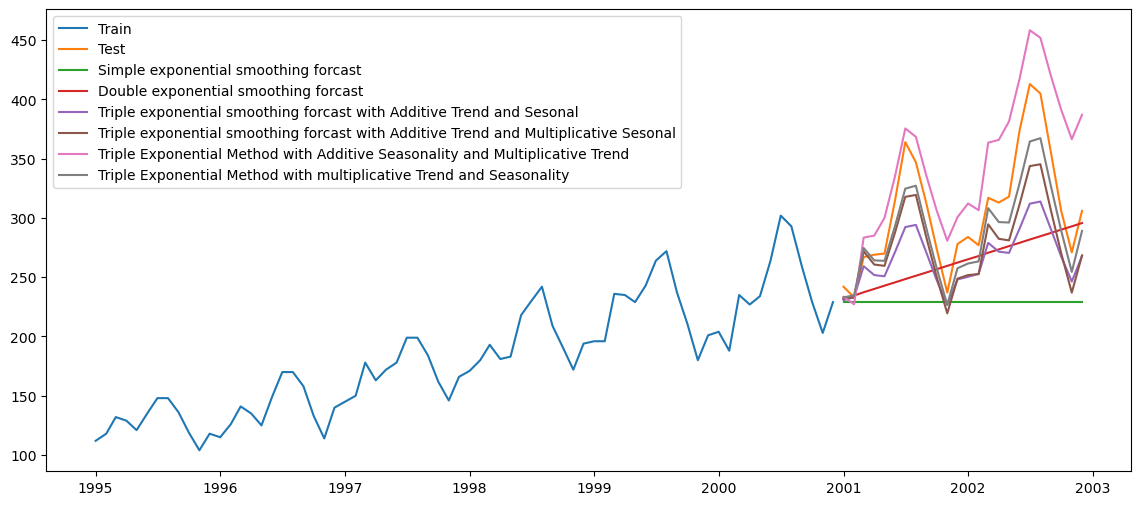

In [47]:
plt.figure(figsize=(14,6))
plt.plot(train_data, label='Train')
plt.plot(test_data, label='Test')
plt.plot(test_pred_ses, label='Simple exponential smoothing forcast')
plt.plot(test_pred_dexp, label='Double exponential smoothing forcast')
plt.plot(test_pred_ad_texp, label='Triple exponential smoothing forcast with Additive Trend and Sesonal')
plt.plot(test_pred_mul_ad_texp, label='Triple exponential smoothing forcast with Additive Trend and Multiplicative Sesonal')
plt.plot(test_pred_ad_mul_texp, label='Triple Exponential Method with Additive Seasonality and Multiplicative Trend')
plt.plot(test_pred_mul_texp, label='Triple Exponential Method with multiplicative Trend and Seasonality')
plt.legend(loc='best')
plt.show()

### Comparing the results

In [48]:
Evaluation = {"Models":pd.Series(["Simple_Exp","Double_Exp","Triple_Exp_Add","Triple_Exp_Mul_Add","Triple_Exp_Add_Mul","Triple_Exp_Mul"]),
        "Train_RMSE":pd.Series([train_rmse_ses,train_rmse_dexp,train_rmse_ad_texp,train_rmse_mul_ad_texp,train_rmse_ad_mul_texp,train_rmse_mul_texp]),
        "Test_MAPE(%)":pd.Series([mape_ses,mape_dexp,mape_ad_texp,mape_mul_ad_texp,mape_ad_mul_texp,mape_mul_texp]),
        "Test_RMSE_Values":pd.Series([test_rmse_ses,test_rmse_dexp,test_rmse_ad_texp,test_rmse_mul_ad_texp,test_rmse_ad_mul_texp,test_rmse_mul_texp])}
table_evaluation = pd.DataFrame(Evaluation)
table_evaluation.sort_values(['Test_MAPE(%)'], inplace=True, ignore_index=True)
table_evaluation

,Models,Train_RMSE,Test_MAPE(%),Test_RMSE_Values
0,Triple_Exp_Mul,6.396750,6.035068,23.058821
1,Triple_Exp_Mul_Add,6.386634,9.368507,34.989901
2,Triple_Exp_Add,7.751304,12.084271,47.568531
3,Triple_Exp_Add_Mul,12.745962,12.720039,45.891606
4,Double_Exp,19.302274,13.790591,59.969152
5,Simple_Exp,19.031772,23.382283,91.113254


### Visualizing Models Performance

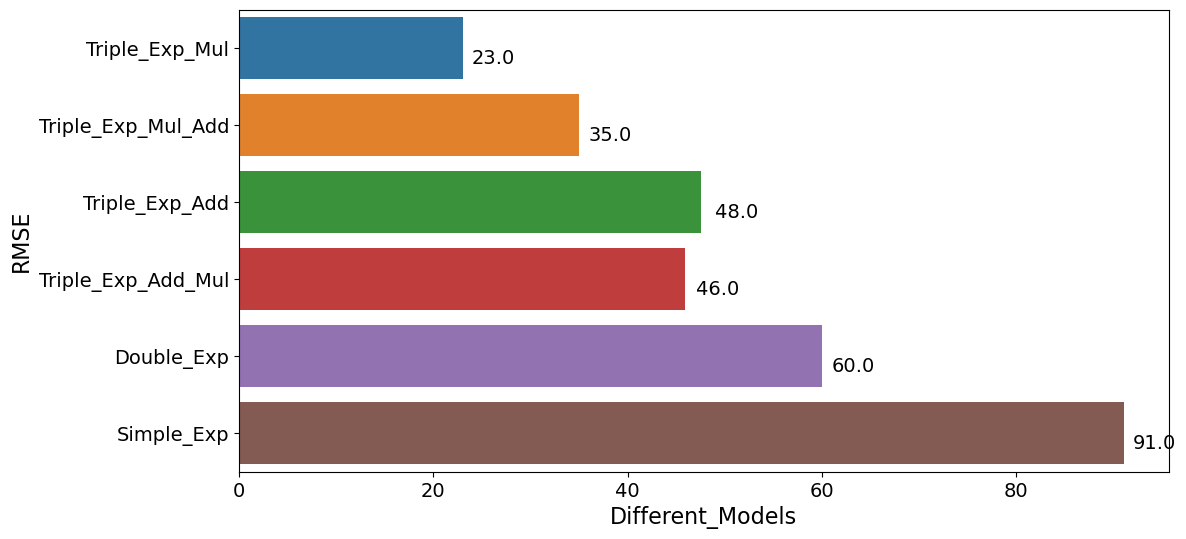

In [49]:
f, axe = plt.subplots(1,1, figsize=(12,6))
sns.barplot(x= 'Test_RMSE_Values', y= 'Models', data= table_evaluation, ax= axe)
axe.set_xlabel('Different_Models', size=16)
axe.set_ylabel('RMSE', size=16)
plt.yticks(fontsize= 14)
plt.xticks(fontsize= 14)

for i, v in enumerate(np.round(table_evaluation.Test_RMSE_Values.values,0)):
    axe.text(v + 1, i + .20, str(v),
            color = 'black', fontsize= 14)
plt.show()

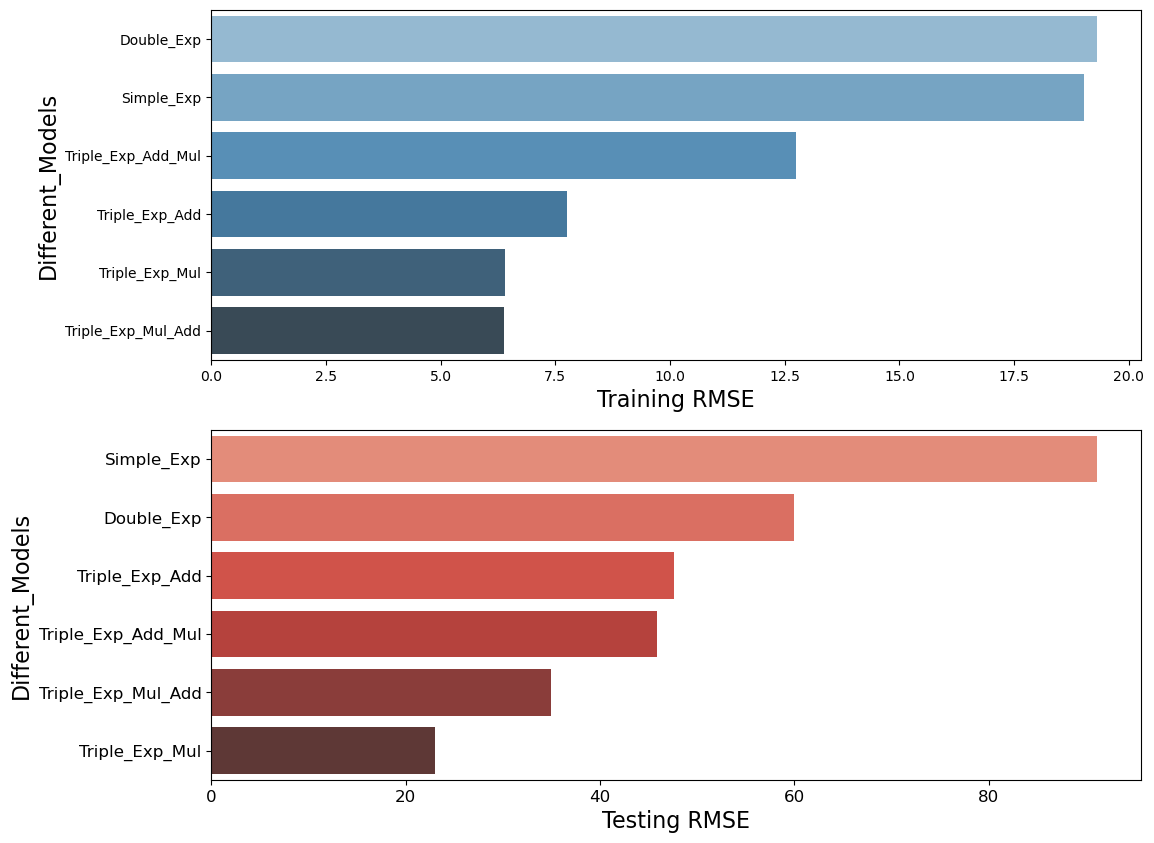

In [50]:
f, axes = plt.subplots(2,1, figsize=(12,10))
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)

train_rmse = table_evaluation.sort_values(by=['Train_RMSE'], ascending=False)

sns.barplot(x='Train_RMSE', y='Models', data = train_rmse, palette='Blues_d', ax = axes[0])
axes[0].set_xlabel('Training RMSE', size=16)
axes[0].set_ylabel('Different_Models', size=16)

test_rmse = table_evaluation.sort_values(by=['Test_RMSE_Values'], ascending=False)

sns.barplot(x='Test_RMSE_Values', y='Models', data = test_rmse, palette='Reds_d', ax = axes[1])
axes[1].set_xlabel('Testing RMSE', size=16)
axes[1].set_ylabel('Different_Models', size=16)

plt.show()

### Autoregressive Integrated Moving Averages (ARIMA)

#### Stationary vs Non-stationary Time Series

##### Test of Stationarity

In [51]:
def test_stationarity(timeseries):
    
    # Determine rolling statistics
    movingAverage = timeseries.rolling(window=12).mean()
    movingSTD = timeseries.rolling(window=12).std()
    
    # Plot rolling statistics
    orig = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(movingAverage, color='red', label='Rolling Mean')
    plt.legend(loc='best')
    plt.title('Rolling Mean')
    plt.show(block=False)
    
    # Perform Dickey–Fuller test:
    print('Results of Dickey Fuller Test:')
    dftest = adfuller(timeseries['Passengers'], autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

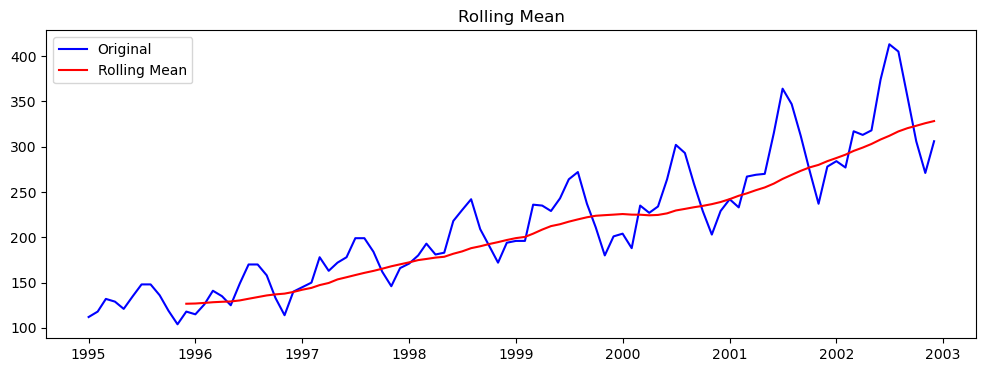

Results of Dickey Fuller Test:
Test Statistic                  1.340248
p-value                         0.996825
#Lags Used                     12.000000
Number of Observations Used    83.000000
Critical Value (1%)            -3.511712
Critical Value (5%)            -2.897048
Critical Value (10%)           -2.585713
dtype: float64


In [52]:
plt.figure(figsize=(12,4))
sales= pd.DataFrame()
sales['Passengers'] = airline[['Passengers']]
test_stationarity(sales)

In [53]:
def adf_test(series):    
    result = adfuller(series.dropna())  
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)
    if result[1] <= 0.05:
        print("Reject the null hypothesis")
        print("Data is stationary")
    else:
        print("Fail to reject the null hypothesis")
        print("Data is non-stationary")

### Feature Scaling (Transformations)

#### Square Root Transform

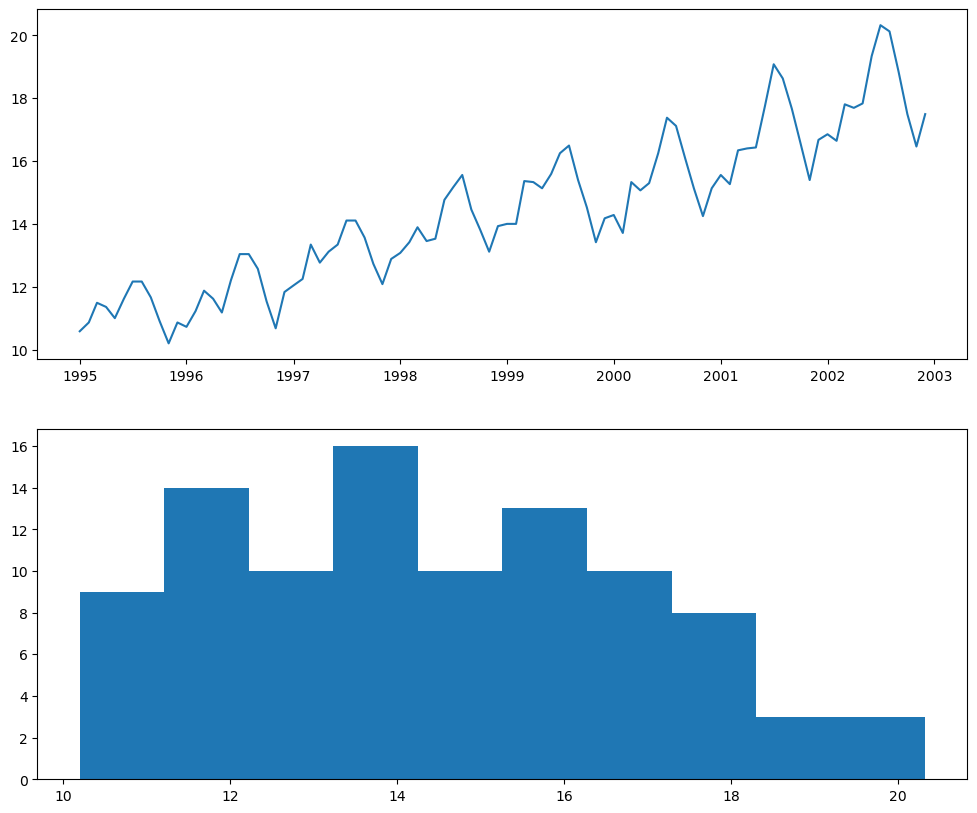

In [54]:
square_root= pd.DataFrame()
square_root = airline[['Passengers']]
square_root['Passengers'] = np.sqrt(square_root.Passengers)

# line chart
fig=plt.figure(figsize=(12,10))
plt.subplot(211)
plt.plot(square_root['Passengers'])

# Histogram
plt.subplot(212)
plt.hist(square_root['Passengers'])
plt.show()

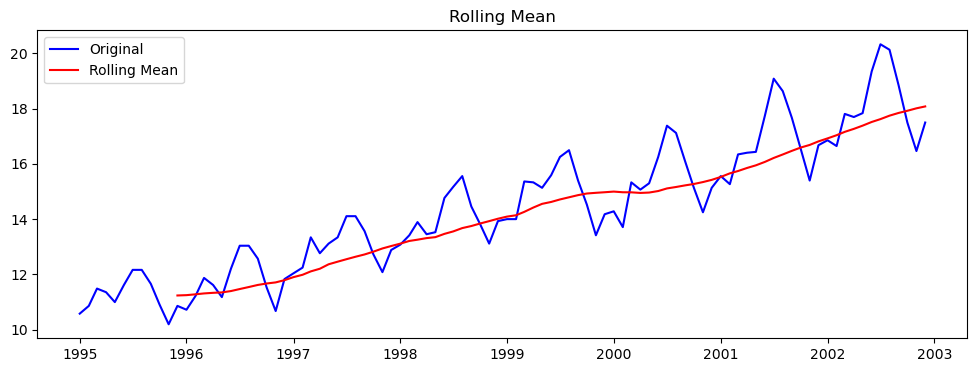

Results of Dickey Fuller Test:
Test Statistic                  0.451435
p-value                         0.983320
#Lags Used                     12.000000
Number of Observations Used    83.000000
Critical Value (1%)            -3.511712
Critical Value (5%)            -2.897048
Critical Value (10%)           -2.585713
dtype: float64


In [55]:
plt.figure(figsize=(12,4))
test_stationarity(square_root)

In [56]:
adf_test(square_root)

Fail to reject the null hypothesis
Data is non-stationary


#### Log Transform

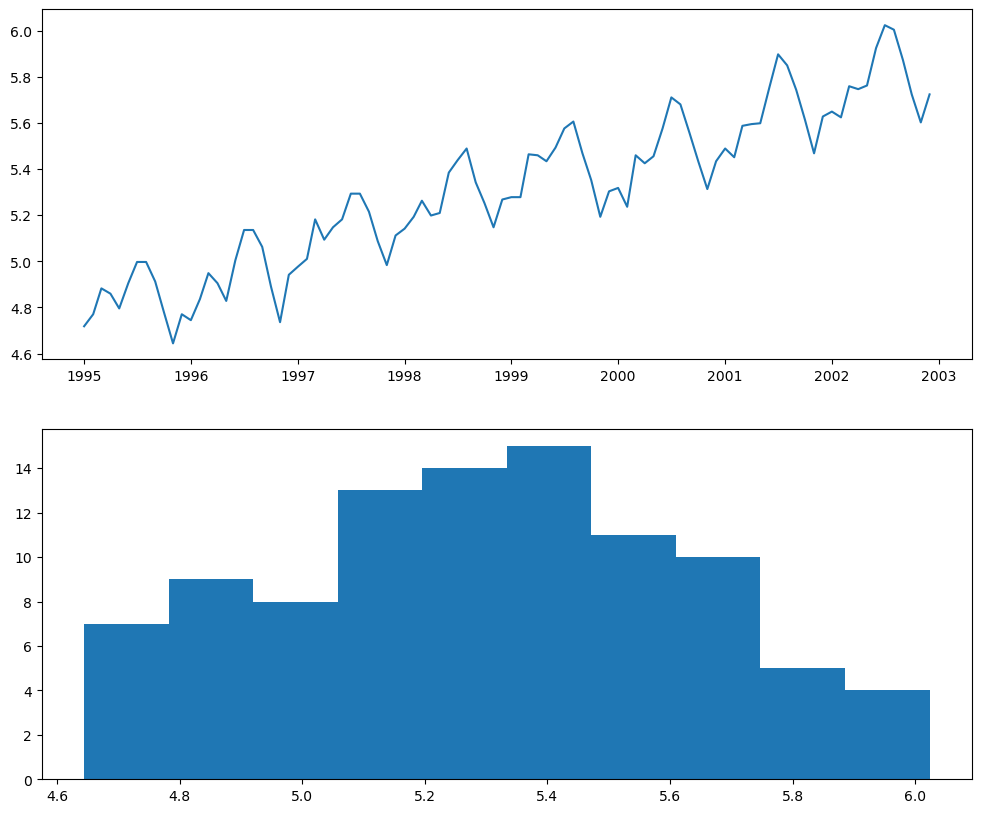

In [57]:
log = pd.DataFrame()
log = airline[['Passengers']]
log['Passengers'] = np.log(log.Passengers)

# line chart
fig = plt.figure(figsize=(12,10))
plt.subplot(211)
plt.plot(log['Passengers'])

# Histogram
plt.subplot(212)
plt.hist(log['Passengers'])
plt.show()


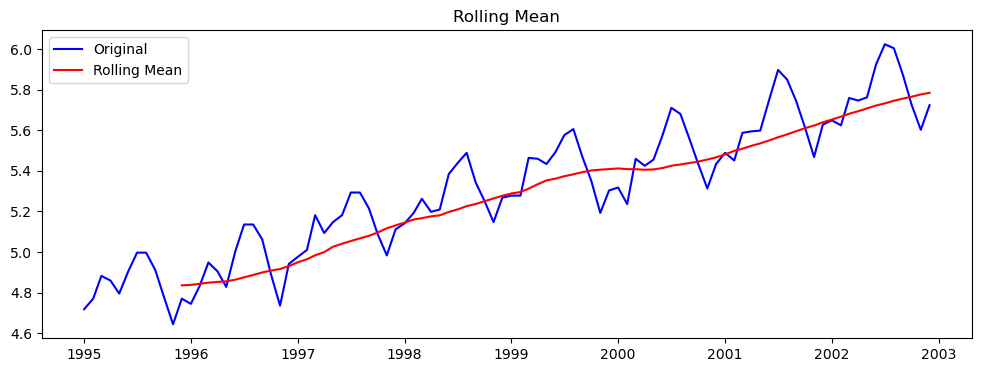

Results of Dickey Fuller Test:
Test Statistic                 -0.723027
p-value                         0.840695
#Lags Used                     12.000000
Number of Observations Used    83.000000
Critical Value (1%)            -3.511712
Critical Value (5%)            -2.897048
Critical Value (10%)           -2.585713
dtype: float64


In [58]:
plt.figure(figsize=(12,4))
test_stationarity(log)

In [59]:
adf_test(log)

Fail to reject the null hypothesis
Data is non-stationary


### Converting Non-Stationary Time Series into Stationary

##### Differencing

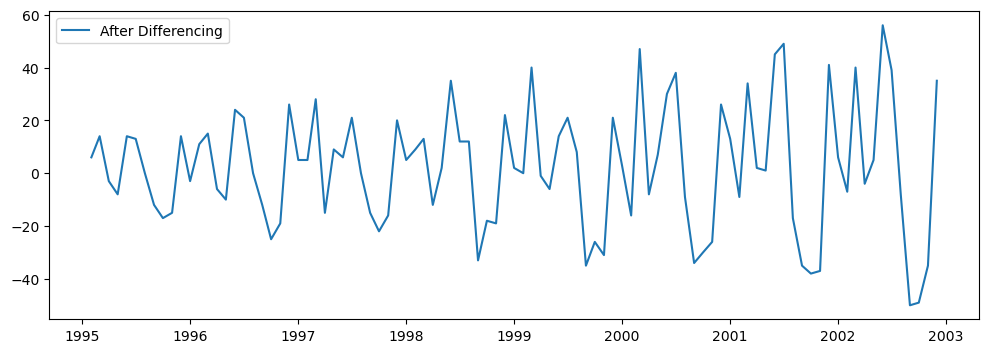

In [60]:
differencing = airline - airline.shift(1)
differencing.dropna(inplace=True)
plt.figure(figsize=(12,4))
plt.plot(differencing, label='After Differencing')
plt.legend(loc='best')
plt.show()

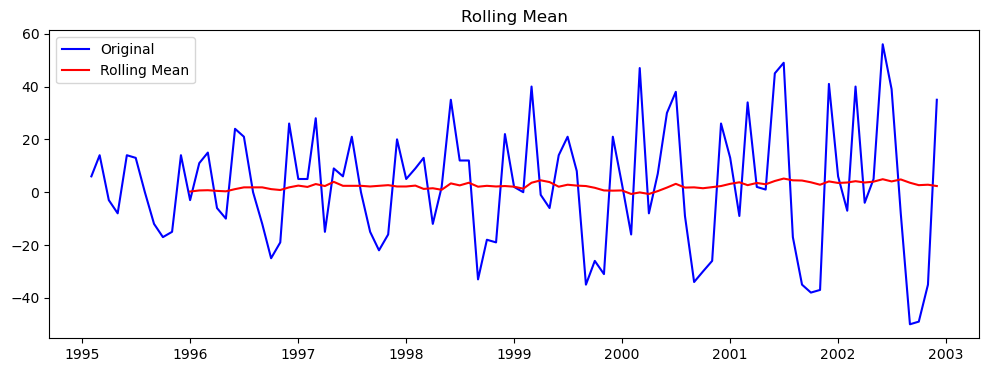

Results of Dickey Fuller Test:
Test Statistic                 -2.150002
p-value                         0.224889
#Lags Used                     12.000000
Number of Observations Used    82.000000
Critical Value (1%)            -3.512738
Critical Value (5%)            -2.897490
Critical Value (10%)           -2.585949
dtype: float64


In [61]:
plt.figure(figsize=(12,4))
test_stationarity(differencing)

In [62]:
adf_test(differencing)

Fail to reject the null hypothesis
Data is non-stationary


#### Seasonal Differencing

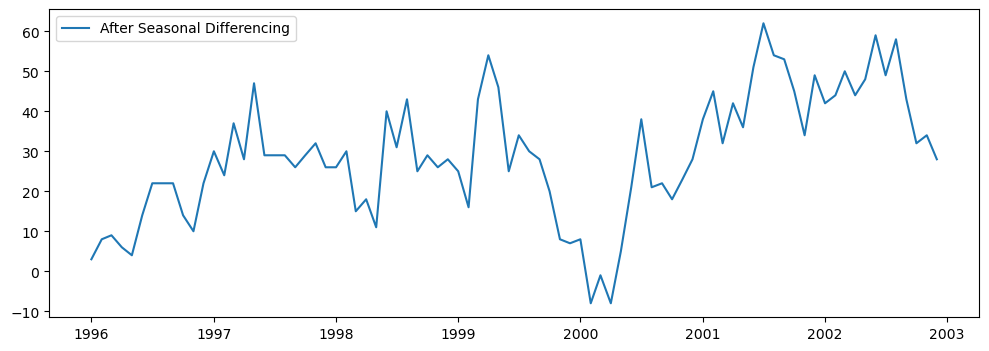

In [63]:
seasonal_differencing = airline - airline.shift(12)
seasonal_differencing.dropna(inplace=True)
plt.figure(figsize=(12,4))
plt.plot(seasonal_differencing, label='After Seasonal Differencing')
plt.legend(loc='best')
plt.show()

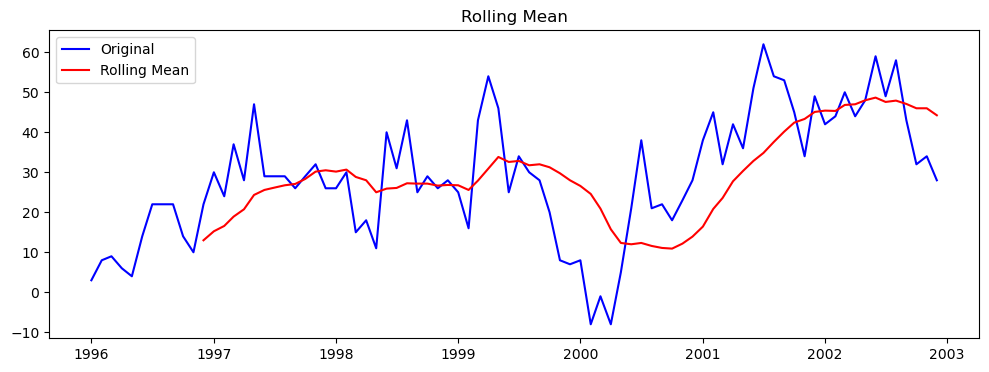

Results of Dickey Fuller Test:
Test Statistic                 -2.690004
p-value                         0.075784
#Lags Used                      1.000000
Number of Observations Used    82.000000
Critical Value (1%)            -3.512738
Critical Value (5%)            -2.897490
Critical Value (10%)           -2.585949
dtype: float64


In [64]:
plt.figure(figsize=(12,4))
test_stationarity(seasonal_differencing)

In [65]:
adf_test(seasonal_differencing)

Fail to reject the null hypothesis
Data is non-stationary


### Transformation

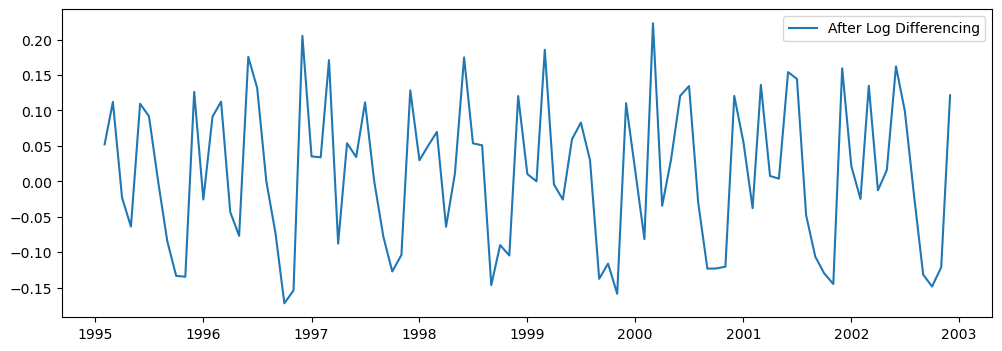

In [66]:
log_diff = log - log.shift(1)
log_diff.dropna(inplace=True)
plt.figure(figsize=(12,4))
plt.plot(log_diff, label='After Log Differencing')
plt.legend(loc='best')
plt.show()

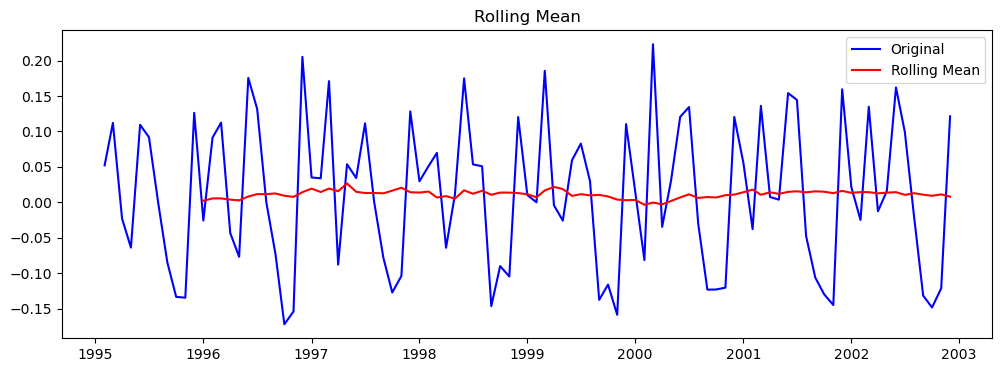

Results of Dickey Fuller Test:
Test Statistic                 -2.670823
p-value                         0.079225
#Lags Used                     12.000000
Number of Observations Used    82.000000
Critical Value (1%)            -3.512738
Critical Value (5%)            -2.897490
Critical Value (10%)           -2.585949
dtype: float64


In [67]:
plt.figure(figsize=(12,4))
test_stationarity(log_diff)

In [68]:
adf_test(log_diff)

Fail to reject the null hypothesis
Data is non-stationary


### Box Cox Transformation

,Passengers
Date,
1995-01-01,4.718499
1995-02-01,4.770685
1995-03-01,4.882802
1995-04-01,4.859812
1995-05-01,4.795791


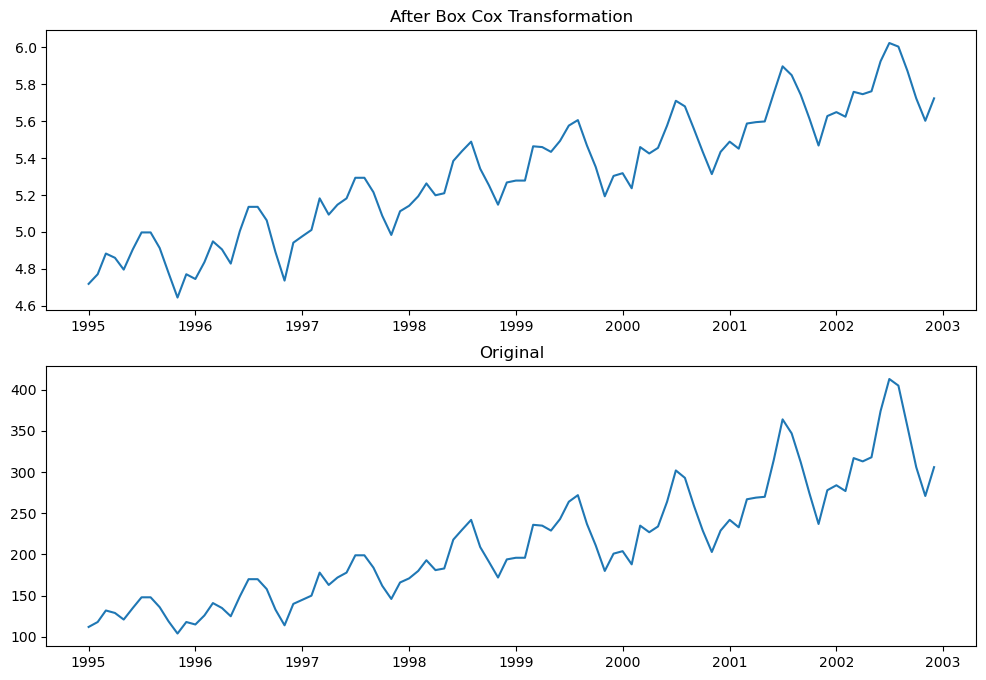

In [69]:
data_boxcox = pd.DataFrame()
data_boxcox['Passengers'] = pd.Series(boxcox(airline['Passengers'], lmbda=0), airline.index)
display(data_boxcox.head())
fig, axis = plt.subplots(2,figsize=(12,8),)
axis[0].plot(data_boxcox)
axis[0].set_title('After Box Cox Transformation')
axis[1].plot(airline, label='original')
axis[1].set_title('Original')
plt.show()

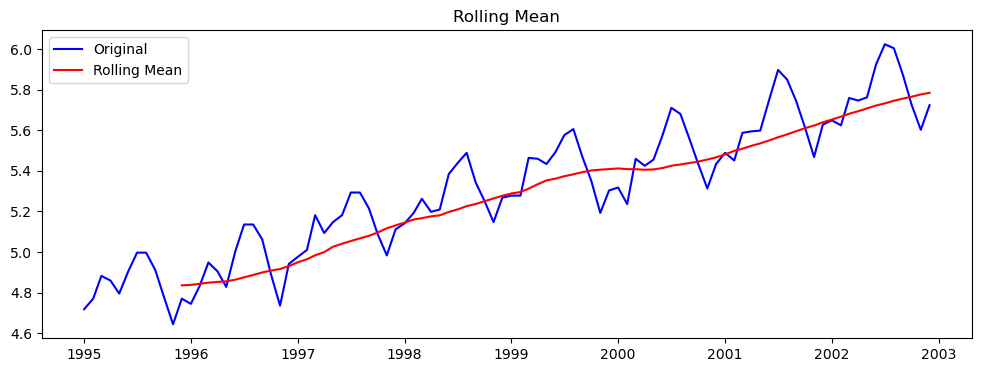

Results of Dickey Fuller Test:
Test Statistic                 -0.723027
p-value                         0.840695
#Lags Used                     12.000000
Number of Observations Used    83.000000
Critical Value (1%)            -3.511712
Critical Value (5%)            -2.897048
Critical Value (10%)           -2.585713
dtype: float64


In [70]:
plt.figure(figsize=(12,4))
test_stationarity(data_boxcox)

In [71]:
adf_test(data_boxcox)

Fail to reject the null hypothesis
Data is non-stationary


#### Differencing of the Box-Cox Transformation

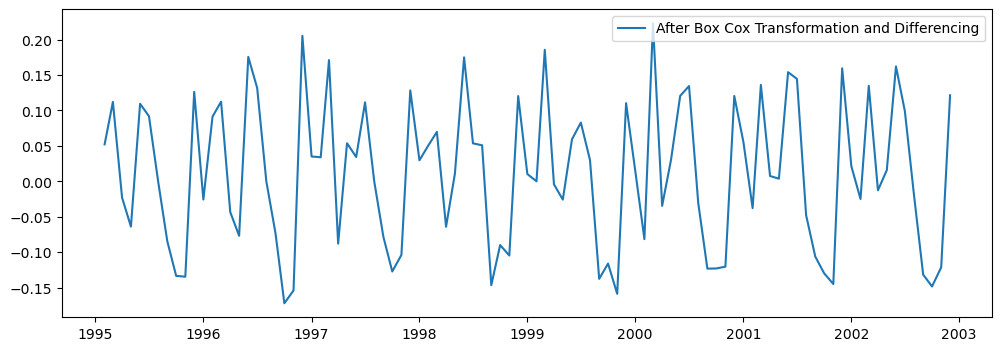

In [72]:
data_boxcox_diff = data_boxcox - data_boxcox.shift()
data_boxcox_diff.dropna(inplace=True)
plt.figure(figsize=(12,4))
plt.plot(data_boxcox_diff, label='After Box Cox Transformation and Differencing')
plt.legend(loc='best')
plt.show()

##### test the Stationarity again

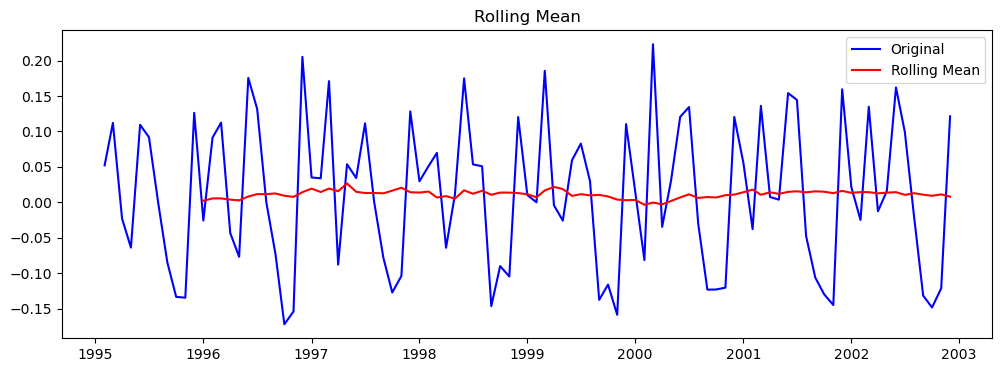

Results of Dickey Fuller Test:
Test Statistic                 -2.670823
p-value                         0.079225
#Lags Used                     12.000000
Number of Observations Used    82.000000
Critical Value (1%)            -3.512738
Critical Value (5%)            -2.897490
Critical Value (10%)           -2.585949
dtype: float64


In [73]:
plt.figure(figsize=(12,4))
test_stationarity(data_boxcox_diff)

In [74]:
adf_test(data_boxcox_diff)

Fail to reject the null hypothesis
Data is non-stationary


### Building The Time Series Forecasting with Optimal Value using ARIMA

In [75]:
train_data_boxcox = data_boxcox[:size]
test_data_boxcox = data_boxcox[size:]
train_data_boxcox_diff = data_boxcox_diff[:size]
test_data_boxcox_diff = data_boxcox_diff[size:]

#### ARIMA Hyperparameter Tuning

In [76]:
# Grid search ARIMA parameters for a time series
# Evaluate an ARIMA model for a given order (p,d,q) and return RMSE

def evaluate_arima_model(X, arima_order):

# Prepare training dataset
    X = X.astype('float32')
    train_size = int(len(X) * 0.70)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]

# Make predictions
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit()
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
        
# Calculate out of sample error
    rmse = sqrt(mean_squared_error(test, predictions))
    return rmse

# Evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float('inf'), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    rmse = evaluate_arima_model(dataset, order)
                    if rmse < best_score:
                        best_score, best_cfg = rmse, order
                except Exception as e:
                    print(e)
                    continue
    print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))

In [77]:
# Evaluate parameters
p_values = range(0,5)
d_values = range(0,5)
q_values = range(0,5)
evaluate_models(train_data_boxcox_diff.Passengers, p_values, d_values, q_values)

Best ARIMA(4, 1, 4) RMSE=0.095


#### Inverse transformation of the Box-Cox Differencing

In [78]:
model = ARIMA(train_data_boxcox_diff, order=(4, 1, 4))
model_fit = model.fit()
y_hat_ar = data_boxcox_diff.copy()
y_hat_ar['arima_forecast'] = model_fit.predict(data_boxcox_diff.index.min(), data_boxcox_diff.index.max())

# We did differencing. So we need to revert it by adding the consecutive observations.
# For that we are using cumsum() method
y_hat_ar['arima_forecast'] = y_hat_ar['arima_forecast'].cumsum()

# We removed the first observations after differencing as it was null. Hence, adding the first observation back.
y_hat_ar['arima_forecast'] = y_hat_ar['arima_forecast'].add(data_boxcox.Passengers[0])

# Now doing the reverse transformation 
# We have done Box Cox Log Log transformation with lambda = 0
# Hence, we have to the exponential as it is the reverse of the log.
y_hat_ar['arima_forecast'] = np.exp(y_hat_ar['arima_forecast'])

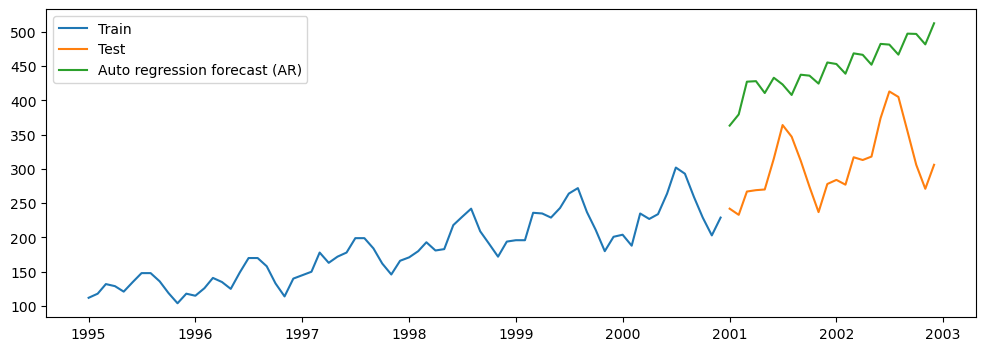

In [79]:
plt.figure(figsize=(12,4))
plt.plot(train_data['Passengers'], label='Train')
plt.plot(test_data, label='Test')
plt.plot(y_hat_ar['arima_forecast'][test_data.index.min():], label='Auto regression forecast (AR)')
plt.legend(loc='best')
plt.show()

### Model Evaluation

#### RMSE (Root Mean Squared Error)

In [84]:
rmse_arima = np.sqrt(mean_squared_error(test_data, y_hat_ar['arima_forecast'][test_data.index.min():])).round(2)
rmse_arima

147.16

#### MAPE (Mean Absolute Percent Error)

In [85]:
mape_arima = round(np.mean(np.abs((test_data.Passengers - y_hat_ar['arima_forecast'][test_data.index.min():])/test_data.Passengers)*100),2)
mape_arima

48.46

#### Analysing the Residuals

##### The mean of the Residual should be zero or close to Zero

In [86]:
model_residual = model_fit.resid
model_residual.mean()

-0.005638508043958925

#### Residuals must be stationary

In [87]:
adf_test(model_residual)

Fail to reject the null hypothesis
Data is non-stationary


#### No autocorrelation between residuals

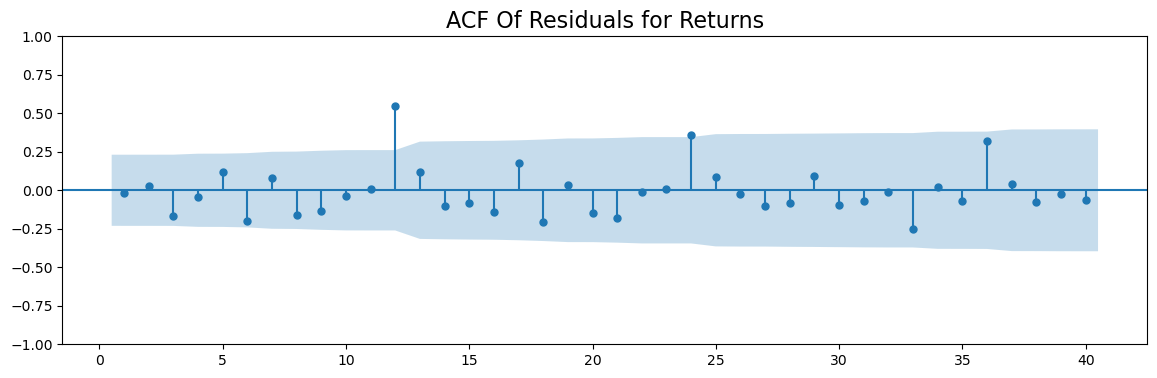

In [88]:
plt.rcParams["figure.figsize"] = (14,4)
plot_acf(model_residual, zero = False, lags = 40)
plt.title("ACF Of Residuals for Returns",size=16)
plt.show()

#### Residuals must be random

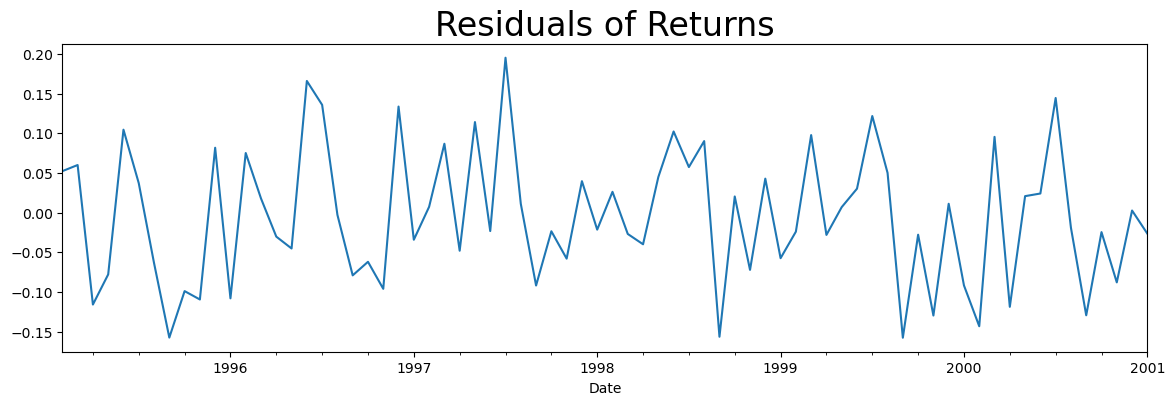

In [89]:
model_residual.plot(figsize=(14,4))
plt.title("Residuals of Returns", size=24)
plt.show()

### Seasonal Auto Regressive Integrated Moving Average (SARIMA)

In [90]:
model = SARIMAX(train_data_boxcox, order=(1,1,1), seasonal_order=(1,1,1,12))
model_fit= model.fit()
y_hat_sarima = data_boxcox_diff.copy()

##### Inverse Transformation of the Differencing Box-Cox Transformation

In [91]:
y_hat_sarima['sarima_forecast_boxcox'] = model_fit.predict(data_boxcox_diff.index.min(), data_boxcox_diff.index.max())
y_hat_sarima['sarima_forecast'] = np.exp(y_hat_sarima['sarima_forecast_boxcox'])
y_hat_sarima['sarima_forecast'] = np.exp(y_hat_sarima['sarima_forecast_boxcox'])

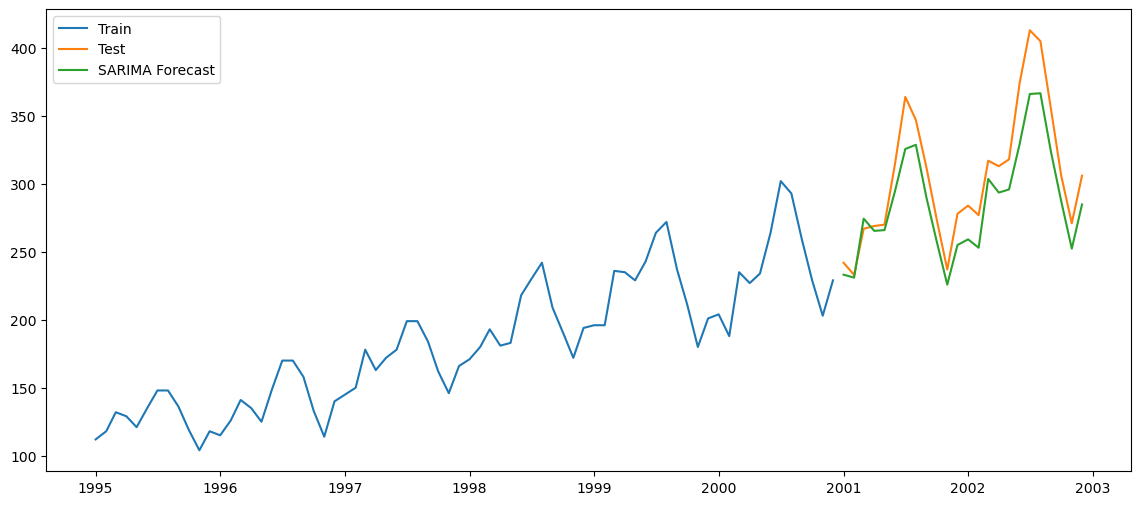

In [92]:
plt.figure(figsize=(14,6))
plt.plot(train_data['Passengers'], label='Train')
plt.plot(test_data, label='Test')
plt.plot(y_hat_sarima['sarima_forecast'][test_data.index.min():], label='SARIMA Forecast')
plt.legend(loc='best')
plt.show()

### Model Evaluation

#### RMSE (Root Mean Squared Error)

In [93]:
rmse_sarima = np.sqrt(mean_squared_error(test_data, y_hat_sarima['sarima_forecast'][test_data.index.min():])).round(2)
rmse_sarima

24.0

#### MAPE (Mean Absolute Percent Error)

In [94]:
mape_sarima = round(np.mean(np.abs((test_data.Passengers - y_hat_sarima['sarima_forecast'][test_data.index.min():])/test_data.Passengers)*100),2)
mape_sarima

6.44

### Analysing the Residuals

In [95]:
model_residual = model_fit.resid
model_residual.mean()

0.03586847936052294

### Residuals must be stationary

In [96]:
adf_test(model_residual)

Reject the null hypothesis
Data is stationary


#### No autocorrelation between residuals

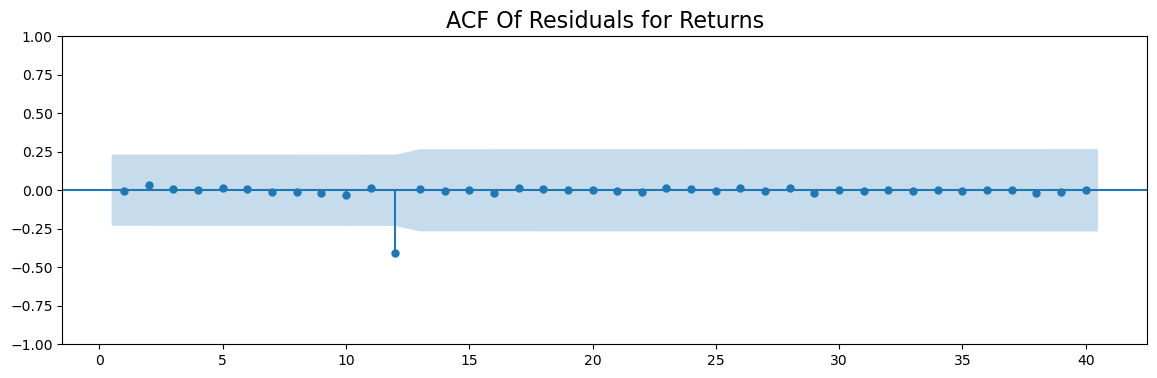

In [97]:
plt.rcParams["figure.figsize"] = (14,4)
plot_acf(model_residual, zero = False, lags = 40)
plt.title("ACF Of Residuals for Returns",size= 16)
plt.show()

#### Residuals must be random

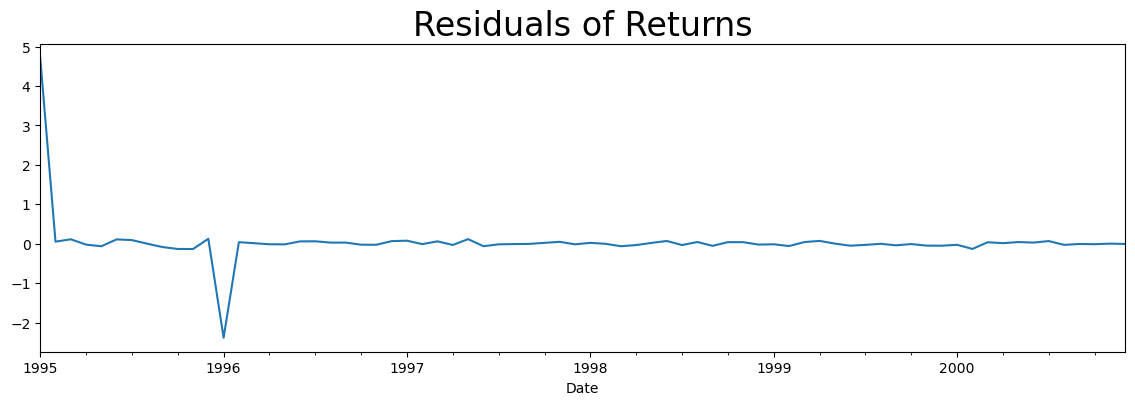

In [98]:
model_residual.plot(figsize=(14,4))
plt.title("Residuals of Returns", size=24)
plt.show()

## Creating model with differente Transformation Technique

### Compareing the results

In [99]:
Evaluation = {"Models":pd.Series(["Simple_Exponential","Double_Exponential","Triple_Exp_Additive","Triple_Exp_Mul_Add","Triple_Exp_Add_Mul","Triple_Exp_Multiplicative","ARIMA","SARIMA"]),
        "MAPE(%)":pd.Series([mape_ses,mape_dexp,mape_ad_texp,mape_mul_ad_texp,mape_ad_mul_texp,mape_mul_texp,mape_arima,mape_sarima]),
        "RMSE_Values":pd.Series([test_rmse_ses,test_rmse_dexp,test_rmse_ad_texp,test_rmse_mul_ad_texp,test_rmse_ad_mul_texp,test_rmse_mul_texp,rmse_arima,rmse_sarima])}
table_evaluation=pd.DataFrame(Evaluation)
table_evaluation.sort_values(['RMSE_Values'], inplace=True, ignore_index=True)
table_evaluation

,Models,MAPE(%),RMSE_Values
0,Triple_Exp_Multiplicative,6.035068,23.058821
1,SARIMA,6.440000,24.000000
2,Triple_Exp_Mul_Add,9.368507,34.989901
3,Triple_Exp_Add_Mul,12.720039,45.891606
4,Triple_Exp_Additive,12.084271,47.568531
5,Double_Exponential,13.790591,59.969152
6,Simple_Exponential,23.382283,91.113254
7,ARIMA,48.460000,147.160000


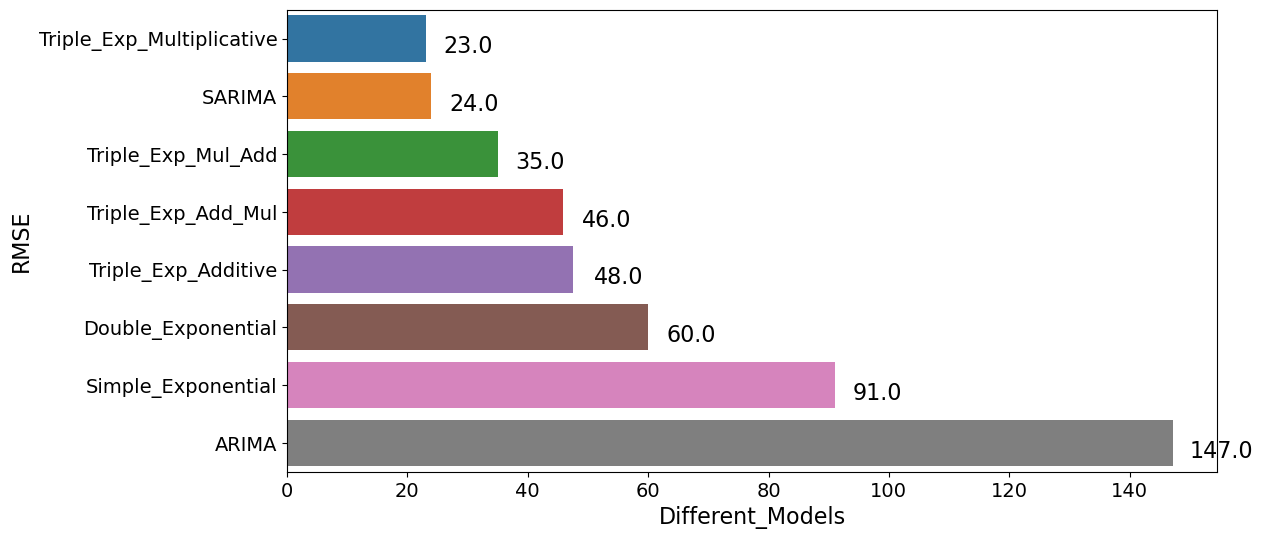

In [100]:
f, axe = plt.subplots(1,1, figsize=(12,6))
sns.barplot(x='RMSE_Values', y='Models', data=table_evaluation, ax = axe)
axe.set_xlabel('Different_Models', size=16)
axe.set_ylabel('RMSE', size=16)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)

for i, v in enumerate(np.round(table_evaluation.RMSE_Values.values,0)):
    axe.text(v + 3, i + .25, str(v), fontsize= 16)

plt.show()

### Data Pre-processing for Model Driven Techniques

#### Creating Dummy Variables of the Categorical Feature Month of Date Time feature

In [101]:
newdata = airline.copy()
newdata.reset_index(inplace=True)
newdata['t'] = np.arange(1,len(newdata)+1)
newdata['t_squared'] = np.square(newdata.t)
newdata["month"] = newdata.Date.dt.strftime("%b") # month extraction
newdata["year"] = newdata.Date.dt.strftime("%Y")  # year extraction
months = pd.get_dummies(newdata['month'])
months = months[['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']]
newdata = pd.concat([newdata,months],axis=1)
newdata['log_passengers'] = np.log(newdata['Passengers'])
newdata

,Date,Passengers,t,t_squared,month,year,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,log_passengers
0,1995-01-01,112,1,1,Jan,1995,True,False,False,False,False,False,False,False,False,False,False,False,4.718499
1,1995-02-01,118,2,4,Feb,1995,False,True,False,False,False,False,False,False,False,False,False,False,4.770685
2,1995-03-01,132,3,9,Mar,1995,False,False,True,False,False,False,False,False,False,False,False,False,4.882802
3,1995-04-01,129,4,16,Apr,1995,False,False,False,True,False,False,False,False,False,False,False,False,4.859812
4,1995-05-01,121,5,25,May,1995,False,False,False,False,True,False,False,False,False,False,False,False,4.795791
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,2002-08-01,405,92,8464,Aug,2002,False,False,False,False,False,False,False,True,False,False,False,False,6.003887
92,2002-09-01,355,93,8649,Sep,2002,False,False,False,False,False,False,False,False,True,False,False,False,5.872118
93,2002-10-01,306,94,8836,Oct,2002,False,False,False,False,False,False,False,False,False,True,False,False,5.723585
94,2002-11-01,271,95,9025,Nov,2002,False,False,False,False,False,False,False,False,False,False,True,False,5.602119


### Splitting data into Train and Test

In [106]:
train_data = newdata.iloc[:size]
test_data = newdata.iloc[size:]

In [107]:
train_data

,Date,Passengers,t,t_squared,month,year,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,log_passengers
0,1995-01-01,112,1,1,Jan,1995,True,False,False,False,False,False,False,False,False,False,False,False,4.718499
1,1995-02-01,118,2,4,Feb,1995,False,True,False,False,False,False,False,False,False,False,False,False,4.770685
2,1995-03-01,132,3,9,Mar,1995,False,False,True,False,False,False,False,False,False,False,False,False,4.882802
3,1995-04-01,129,4,16,Apr,1995,False,False,False,True,False,False,False,False,False,False,False,False,4.859812
4,1995-05-01,121,5,25,May,1995,False,False,False,False,True,False,False,False,False,False,False,False,4.795791
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67,2000-08-01,293,68,4624,Aug,2000,False,False,False,False,False,False,False,True,False,False,False,False,5.680173
68,2000-09-01,259,69,4761,Sep,2000,False,False,False,False,False,False,False,False,True,False,False,False,5.556828
69,2000-10-01,229,70,4900,Oct,2000,False,False,False,False,False,False,False,False,False,True,False,False,5.433722
70,2000-11-01,203,71,5041,Nov,2000,False,False,False,False,False,False,False,False,False,False,True,False,5.313206


In [108]:
test_data

,Date,Passengers,t,t_squared,month,year,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,log_passengers
72,2001-01-01,242,73,5329,Jan,2001,True,False,False,False,False,False,False,False,False,False,False,False,5.488938
73,2001-02-01,233,74,5476,Feb,2001,False,True,False,False,False,False,False,False,False,False,False,False,5.451038
74,2001-03-01,267,75,5625,Mar,2001,False,False,True,False,False,False,False,False,False,False,False,False,5.587249
75,2001-04-01,269,76,5776,Apr,2001,False,False,False,True,False,False,False,False,False,False,False,False,5.594711
76,2001-05-01,270,77,5929,May,2001,False,False,False,False,True,False,False,False,False,False,False,False,5.598422
77,2001-06-01,315,78,6084,Jun,2001,False,False,False,False,False,True,False,False,False,False,False,False,5.752573
78,2001-07-01,364,79,6241,Jul,2001,False,False,False,False,False,False,True,False,False,False,False,False,5.897154
79,2001-08-01,347,80,6400,Aug,2001,False,False,False,False,False,False,False,True,False,False,False,False,5.849325
80,2001-09-01,312,81,6561,Sep,2001,False,False,False,False,False,False,False,False,True,False,False,False,5.743003
81,2001-10-01,274,82,6724,Oct,2001,False,False,False,False,False,False,False,False,False,True,False,False,5.613128


### Building Ordinary Square Model

### Linear Model

In [109]:
linear_model = smf.ols('Passengers~t',data=train_data).fit()
pred_linear =  pd.Series(linear_model.predict(pd.DataFrame(test_data['t'])))
rmse_linear = np.sqrt(np.mean((np.array(test_data['Passengers'])-np.array(pred_linear))**2))
rmse_linear

51.667792995646266

### Exponential Model

In [110]:
exp = smf.ols('log_passengers~t',data=train_data).fit()
pred_exp = pd.Series(exp.predict(pd.DataFrame(test_data['t'])))
rmse_exp = np.sqrt(np.mean((np.array(test_data['Passengers'])-np.array(np.exp(pred_exp)))**2))
rmse_exp


42.552328946004586

### Quadratic Model

In [111]:
quad = smf.ols('Passengers~t+t_squared',data=train_data).fit()
pred_quad = pd.Series(quad.predict(test_data[["t","t_squared"]]))
rmse_quad = np.sqrt(np.mean((np.array(test_data['Passengers'])-np.array(pred_quad))**2))
rmse_quad

51.990736401555004

### Additive seasonality

In [112]:
add_sea = smf.ols('Passengers~Jan+Feb+Mar+Apr+May+Jun+Jul+Aug+Sep+Oct+Nov+Dec',data=train_data).fit()
pred_add_sea = pd.Series(add_sea.predict(test_data[['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']]))
rmse_add_sea = np.sqrt(np.mean((np.array(test_data['Passengers'])-np.array(pred_add_sea))**2))
rmse_add_sea

127.26451565320338

### Additive Seasonality Quadratic

In [113]:
add_sea_quad = smf.ols('Passengers~t+t_squared+Jan+Feb+Mar+Apr+May+Jun+Jul+Aug+Sep+Oct+Nov+Dec',data=train_data).fit()
pred_add_sea_quad = pd.Series(add_sea_quad.predict(test_data[['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec','t','t_squared']]))
rmse_add_sea_quad = np.sqrt(np.mean((np.array(test_data['Passengers'])-np.array(pred_add_sea_quad))**2))
rmse_add_sea_quad

35.24160848594398

### Multiplicative Seasonality

In [114]:
mul_sea = smf.ols('log_passengers~Jan+Feb+Mar+Apr+May+Jun+Jul+Aug+Sep+Oct+Nov+Dec',data = train_data).fit()
pred_mult_sea = pd.Series(mul_sea.predict(test_data))
rmse_mult_sea = np.sqrt(np.mean((np.array(test_data['Passengers'])-np.array(np.exp(pred_mult_sea)))**2))
rmse_mult_sea

132.1876280026344

### Multiplicative Additive Seasonality

In [115]:
mul_add_sea = smf.ols('log_passengers~t+Jan+Feb+Mar+Apr+May+Jun+Jul+Aug+Sep+Oct+Nov+Dec',data = train_data).fit()
pred_mult_add_sea = pd.Series(mul_add_sea.predict(test_data))
rmse_mult_add_sea = np.sqrt(np.mean((np.array(test_data['Passengers'])-np.array(np.exp(pred_mult_add_sea)))**2))
rmse_mult_add_sea

11.714670246781006

In [116]:
np.exp(pred_mult_add_sea)

72    245.378110
73    251.466317
74    290.915247
75    278.690401
76    275.377947
77    308.136092
78    340.898573
79    343.777446
80    308.799188
81    271.947832
82    238.912819
83    273.505888
84    280.894281
85    287.863698
86    333.022490
87    319.028212
88    315.236312
89    352.735890
90    390.240432
91    393.535995
92    353.494963
93    311.309720
94    273.493201
95    313.093291
dtype: float64

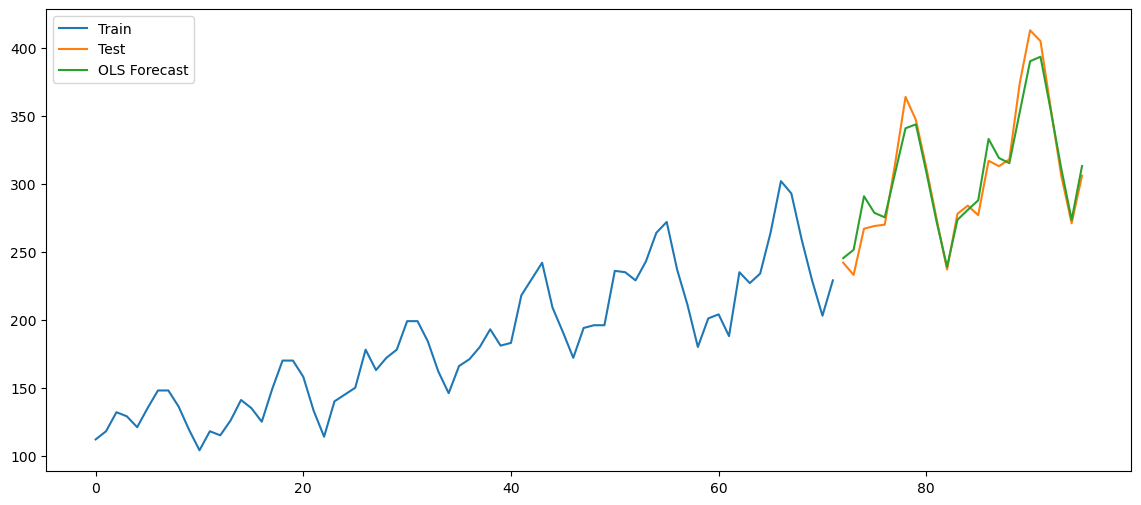

In [117]:
plt.figure(figsize=(14,6))
plt.plot(train_data['Passengers'], label='Train')
plt.plot(test_data['Passengers'], label='Test')
plt.plot(np.exp(pred_mult_add_sea), label='OLS Forecast')
plt.legend(loc='best')
plt.show()

### Compare the results

In [118]:
data = {"Models":pd.Series(["RMSE_Linear","RMSE_Exp","RMSE_Quad","RMSE_Add_Sea","RMSE_Add_Sea_Quad","RMSE_Mult_Sea","RMSE_Mult_Add_Sea"]),
        "RMSE_Values":pd.Series([rmse_linear,rmse_exp,rmse_quad,rmse_add_sea,rmse_add_sea_quad,rmse_mult_sea,rmse_mult_add_sea])}
table_rmse=pd.DataFrame(data)
table_rmse.sort_values(['RMSE_Values'], inplace=True, ignore_index=True)

In [119]:
e = pd.concat([table_rmse,table_evaluation])
e.drop('MAPE(%)', axis=1, inplace=True)
e.sort_values(['RMSE_Values'], inplace=True, ignore_index=True)

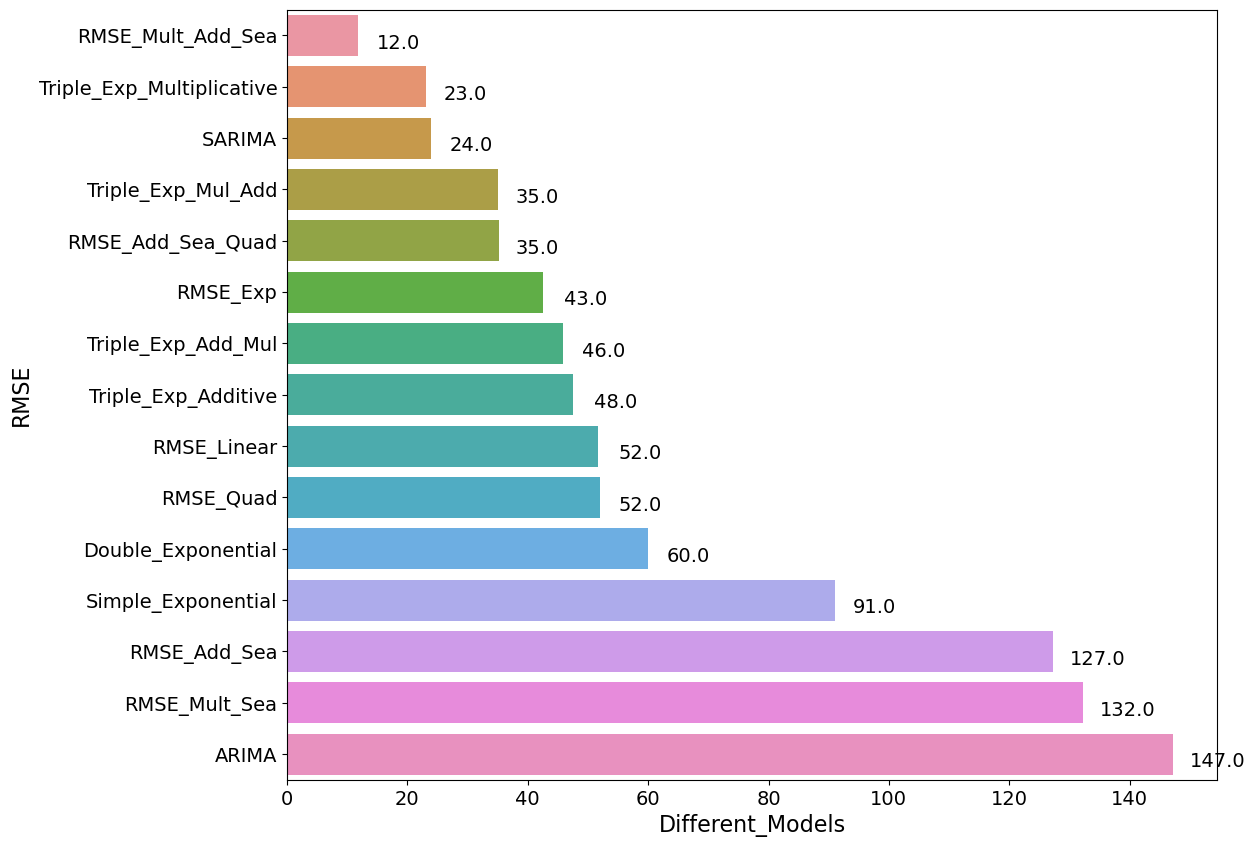

In [120]:
f, axe = plt.subplots(1,1, figsize=(12,10))
sns.barplot(x='RMSE_Values', y='Models', data=e, ax = axe)
axe.set_xlabel('Different_Models', size=16)
axe.set_ylabel('RMSE', size=16)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)

for i, v in enumerate(np.round(e.RMSE_Values.values,0)):
    axe.text(v + 3, i + .25, str(v), fontsize= 14)

plt.show()